### Purpose: 
    Predicting the federal funds rate for the next year given economic indicators.
 
### Background: 
    The Federal Funds rate is the "the interest rate at which depository institutions (mainly banks) lend reserve balances to other depository institutions overnight on an uncollateralized basis". In other words, banks have a reserve that they must maintain by regulation, and these funds can be lent out overnight or for a short-term period with an interest rate rnage that is set by the Federal Open Market Committee (FOMC). The FOMC is apart of the Federal Reserve. The federal funds rate influences monetary policy (Quantitative tightening (QT) and Quantitative easening (QE)), inflation, consumer interest rates, borrowing costs, and the economic environment. 

## Data Collection: 
    I collected data from two different sources: FRED and Yahoo Finance. Data was collected through dates 1/1/1960 to 9/11/24. This is before the FOMC meeting on September 18th. 
    
| Column in Dataset        | Explanation |
|:------------------------:|:-----------:|
|  FFER                    |  Federal Funds Effective Rate (%)     |
|  10-year Treasury Yeild  |  Market Yield on U.S. Treasury Securities at 10-year Constant Maturity, Quoted on an Investment Basis   (%)  |
|  CPI-U                   |  Consumer Price Index for All Urban Consumers: All Items in U.S. City Average |
|  Core CPI                |  Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average       |
|  Unemployment Rate       |  Self-explanatory      |
|  GDP                     |  Real Gross Domestic Product (GDPC1)     |
|  Non-Farm Payrolls       |  All Employees, Total Nonfarm (PAYEMS)    |
|  S&P 500                 |  S&P 500 Closing values      |
|  ^DJI                    |  Dow Jones Composite Index:      |
|  ^VIX                    |  Fear/Volatility Index    |
|  ^TNX                    |  ^TNX: CBOE Interest Rate 10 Year T No (^TNX)     |
|  ^IXIC                   |  Nasdaq Composite       |
|  ^FVX                    | Treasury Yield 5 Years (^FVX)      |
|  ^TYX                    |  Treasury Yield 30 Years (^TYX)      |
|  ^IRX                    |  13 WEEK TREASURY BILL (^IRX)      |
|  CL=F                    |  Crude Oil Oct 24 (CL=F)      |
|  GC=F                    |  Gold Dec 24 (GC=F)|
|  PCE                     |  Personal Consumption Expenditures (PCE)      |

    Each of these are different datasets that will be combined. I will attach the csv files, so this code can be ran. 


## Data Prepartion
    In this section, I will be combining the datasets collected in to one data set that can be easily analyzed. 

In [106]:
#Download necessary packages
!pip install holidays
!pip install tensorflow

In [107]:
#Import all neccessary packages 
import pandas as pd
import numpy as np
import os 
from functools import reduce  # Importing reduce from functools
import holidays
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [108]:
os.chdir('/Users/brim/Desktop/DS Practicum I/Fed Funds Rate/')

In [109]:
ffer = pd.read_csv('FederalFundsEffectiveRate.csv')
ten_year_treas = pd.read_csv('10 Year Treasury Yeild.csv')
CPI = pd.read_csv('CPI-U.csv')
C_cpi = pd.read_csv('Core CPI.csv')
unem = pd.read_csv('Unemployment_Rate.csv')
GDP = pd.read_csv('GDPC1.csv')
nf_payroll = pd.read_csv('All Employees, Total Nonfarm.csv')
SP_500 = pd.read_csv('S&P 500.csv')
DJI = pd.read_csv('^DJI.csv')
VIX = pd.read_csv('^VIX.csv')
TNX = pd.read_csv('^TNX.csv')
IXIC = pd.read_csv('^IXIC.csv')
FVX = pd.read_csv('^FVX.csv')
TYX = pd.read_csv('^TYX.csv')
IRX = pd.read_csv('^IRX.csv')
CL_F = pd.read_csv('CL=F.csv')
GC_F = pd.read_csv('GC=F.csv')
PCE = pd.read_csv('PCE.csv')

In [110]:
dataframes = [ffer, ten_year_treas, CPI, C_cpi, unem, GDP, nf_payroll, SP_500, DJI, VIX, TNX, IXIC, 
              FVX, TYX, IRX, CL_F, GC_F, PCE]

    As seen below, there are some things to edit before merging. 
    1. Keep only Close values for data frames with more features
    2. Ensure there is normal naming convention for each Close value
    3. Ensure the date values are in the same format

In [111]:
for df in dataframes:
    print(df.tail())
    dtype={'date_column': str}

            DATE  FFER
23626   9/7/2024  5.33
23627   9/8/2024  5.33
23628   9/9/2024  5.33
23629  9/10/2024  5.33
23630  9/11/2024  5.33
            DATE 10-year Treasury Yield
16352   9/5/2024                   3.73
16353   9/6/2024                   3.72
16354   9/9/2024                    3.7
16355  9/10/2024                   3.65
16356  9/11/2024                   3.65
         DATE    CPI-U
771  4/1/2024  313.207
772  5/1/2024  313.225
773  6/1/2024  313.049
774  7/1/2024  313.534
775  8/1/2024  314.121
         DATE  Core CPI
807  4/1/2024   317.622
808  5/1/2024   318.140
809  6/1/2024   318.346
810  7/1/2024   318.872
811  8/1/2024   319.768
         DATE  Unemployment Rate
771  4/1/2024                3.9
772  5/1/2024                4.0
773  6/1/2024                4.1
774  7/1/2024                4.3
775  8/1/2024                4.2
          DATE        GDP
253   4/1/2023  22225.350
254   7/1/2023  22490.692
255  10/1/2023  22679.255
256   1/1/2024  22758.752
257   4/1/20

#### Deleting unneccessary columns in the data frames 
The data frames in the list below contain more columns than neccessary for the scope of this project. The only data needed in these columns is the close value. 

In [112]:
dataframes_need_editing = [SP_500, DJI, VIX, TNX, IXIC, 
              FVX, TYX, IRX, CL_F, GC_F]

In [113]:
# Create a dictionary mapping names to the dataframes
dataframes_with_names = {
    "SP_500": SP_500,
    "DJI": DJI,
    "VIX": VIX,
    "TNX": TNX,
    "IXIC": IXIC,
    "FVX": FVX,
    "TYX": TYX,
    "IRX": IRX,
    "CL_F": CL_F,
    "GC_F": GC_F,
}

In [114]:
for name, dataframe in dataframes_with_names.items():
    # Drop unnecessary columns
    dataframe.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)
    # Rename the 'Close' column 
    dataframe.rename(columns={'Close': f'Close_{name}'}, inplace=True)

In [115]:
#creates a list of the edited columns, changes the naming convention, and data type of Data
edited_dataframes = [ffer, ten_year_treas, CPI, C_cpi, unem, GDP, nf_payroll, SP_500, DJI, VIX, TNX, IXIC, 
              FVX, TYX, IRX, CL_F, GC_F, PCE]
for dataframe in edited_dataframes:
        dataframe.rename(columns={'DATE': 'Date'}, inplace=True)
        dataframe['Date'] = pd.to_datetime(dataframe['Date'], format='%m/%d/%Y', errors='coerce')

In [116]:
#Printing the first 5 rows of each data frame to verify naming conventions
for df in edited_dataframes: 
    print(df.head())

        Date  FFER
0 1960-01-01   4.0
1 1960-01-02   4.0
2 1960-01-03   4.0
3 1960-01-04   4.0
4 1960-01-05   4.0
        Date 10-year Treasury Yield
0 1962-01-02                   4.06
1 1962-01-03                   4.03
2 1962-01-04                   3.99
3 1962-01-05                   4.02
4 1962-01-08                   4.03
        Date  CPI-U
0 1960-01-01  29.37
1 1960-02-01  29.41
2 1960-03-01  29.41
3 1960-04-01  29.54
4 1960-05-01  29.57
        Date  Core CPI
0 1957-01-01      28.5
1 1957-02-01      28.6
2 1957-03-01      28.7
3 1957-04-01      28.8
4 1957-05-01      28.8
        Date  Unemployment Rate
0 1960-01-01                5.2
1 1960-02-01                4.8
2 1960-03-01                5.4
3 1960-04-01                5.2
4 1960-05-01                5.1
        Date       GDP
0 1960-01-01  3517.181
1 1960-04-01  3498.246
2 1960-07-01  3515.385
3 1960-10-01  3470.278
4 1961-01-01  3493.703
        Date  Nonfarm Payrolls
0 1939-01-01             29923
1 1939-02-01        

In [117]:
#find the range of dates for each data frame and determine how many days are between each consecutive row
names_of_df = ['ffer', 'ten_year_treas', 'CPI', 'C_cpi', 'unem', 'GDP', 'nf_payroll', 'SP_500', 'DJI', 'VIX', 
               'TNX', 'IXIC','FVX', 'TYX', 'IRX', 'CL_F', 'GC_F', 'PCE']
for name, df in zip(names_of_df, edited_dataframes):
    date_min = df['Date'].min()
    date_max = df['Date'].max()
    date_range = date_max - date_min
    
    print(f"{name}:")
    print(f"  Min Value: {date_min}")
    print(f"  Max Value: {date_max}")
    print(f"  Range: {date_range}\n")
    
    date_diff = df['Date'].diff().dropna() # calculates difference between each element the previous element
    print(date_diff)

ffer:
  Min Value: 1960-01-01 00:00:00
  Max Value: 2024-09-11 00:00:00
  Range: 23630 days 00:00:00

1       1 days
2       1 days
3       1 days
4       1 days
5       1 days
         ...  
23626   1 days
23627   1 days
23628   1 days
23629   1 days
23630   1 days
Name: Date, Length: 23630, dtype: timedelta64[ns]
ten_year_treas:
  Min Value: 1962-01-02 00:00:00
  Max Value: 2024-09-11 00:00:00
  Range: 22898 days 00:00:00

1       1 days
2       1 days
3       1 days
4       3 days
5       1 days
         ...  
16352   1 days
16353   1 days
16354   3 days
16355   1 days
16356   1 days
Name: Date, Length: 16356, dtype: timedelta64[ns]
CPI:
  Min Value: 1960-01-01 00:00:00
  Max Value: 2024-08-01 00:00:00
  Range: 23589 days 00:00:00

1     31 days
2     29 days
3     31 days
4     30 days
5     31 days
        ...  
771   31 days
772   30 days
773   31 days
774   30 days
775   31 days
Name: Date, Length: 775, dtype: timedelta64[ns]
C_cpi:
  Min Value: 1957-01-01 00:00:00
  Max Value: 

    From above, we can decipher this:

| Column in Dataset  | Frequency of Reporting | Date Range |
|:------------------:|:----------------------:|:-----------|
|  FFER              | Daily       |01/01/1960 - 09/11/2024
|  10 year treasury  | Daily       |01/01/1962 - 09/11/2024
|  CPI               | Monthly     |01/01/1960 - 08/01/2024
|  Core CPI          | Monthly     |01/01/1957 - 08/01/2024
|  Unemployment      | Monthly     |01/01/1960 - 08/01/2024
|  GDP               | Quarterly   |01/01/1960 - 04/01/2024
|  Non-farm payrolls | Monthly     |01/01/1939 - 08/01/2024
|  S&P 500           | Daily       |01/04/1960 - 08/30/2024
|  DJI               | Daily       |01/03/1992 - 09/13/2024
|  VIX               | Daily       |01/03/1990 - 09/13/2024
|  TNX               | Daily       |01/03/1962 - 09/13/2024
|  IXIC              | Daily       |02/08/1971 - 09/13/2024
|  FVX               | Daily       |01/03/1962 - 09/13/2024
|  TYX               | Daily       |02/16/1977 - 09/13/2024
|  IRX               | Daily       |01/05/1960 - 09/14/2024
|  CL_F              | Daily       |08/24/2000 - 09/16/2024
|  GC_F              | Daily       |08/31/2000 - 09/16/2024
|  PCE               | Monthly     |01/01/1960 - 07/01/2024

    Before merging the data frames, all data frames need to have the same dates and date range. They will all need to be reindexed to have those dates. This will preserve the existing data while the rest will be NaN.


In [118]:
"""
This code creates a date data frame of the range below and merges each data frame in the list on the date column. 
This ensures that each data frame will have a consistent date range, filling in any missing values with NaN. 
"""
date_range = pd.date_range(start = '1939-01-01', end = '2024-09-16', freq='D')
date_df = pd.DataFrame({'Date': date_range})
for i in range(len(edited_dataframes)):
    edited_dataframes[i] = pd.merge(date_df, edited_dataframes[i], on='Date', how='left')

In [119]:
for df in edited_dataframes:
    actual_rows = len(df)
    print(actual_rows)

31306
31306
31306
31306
31306
31306
31306
31306
31306
31306
31306
31306
31306
31306
31306
31306
31306
31306


In [120]:
expected_rows = len(pd.date_range(start='1939-01-01', end='2024-09-16', freq='D'))
expected_rows

31306

In [121]:
"""
This code intializes a list of data frames. The following lines use the reduce function to perform an outer merge
on the dataframes in the data set, which creates the merged_df. The index is reset and the values are then sorted 
by the date
"""

edited_dataframes = [ffer, ten_year_treas, CPI, C_cpi, unem, GDP, nf_payroll, SP_500, DJI, VIX, TNX, IXIC, 
              FVX, TYX, IRX, CL_F, GC_F, PCE]

In [122]:
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), edited_dataframes)

In [123]:
merged_df = merged_df.reset_index(drop=True)

In [124]:
merged_df = merged_df.sort_values(by='Date')

In [125]:
merged_df.head()

Date  FFER 10-year Treasury Yield  CPI-U  Core CPI  \
23667 1939-01-01   NaN                    NaN    NaN       NaN   
23668 1939-02-01   NaN                    NaN    NaN       NaN   
23669 1939-03-01   NaN                    NaN    NaN       NaN   
23670 1939-04-01   NaN                    NaN    NaN       NaN   
23671 1939-05-01   NaN                    NaN    NaN       NaN   

       Unemployment Rate  GDP  Nonfarm Payrolls  Close_SP_500  Close_DJI  \
23667                NaN  NaN           29923.0           NaN        NaN   
23668                NaN  NaN           30100.0           NaN        NaN   
23669                NaN  NaN           30280.0           NaN        NaN   
23670                NaN  NaN           30094.0           NaN        NaN   
23671                NaN  NaN           30299.0           NaN        NaN   

       Close_VIX  Close_TNX  Close_IXIC  Close_FVX  Close_TYX  Close_IRX  \
23667        NaN        NaN         NaN        NaN        NaN        NaN   
23668        NaN        NaN         NaN        NaN        NaN        NaN   
23669        NaN        NaN         NaN        NaN        NaN        NaN   
23670        NaN        NaN         NaN        NaN        NaN        NaN   
23671        NaN        NaN         NaN        NaN        NaN        NaN   

       Close_CL_F  Close_GC_F  PCE  
23667         NaN         NaN  NaN  
23668         NaN         NaN  NaN  
23669         NaN         NaN  NaN  
23670         NaN         NaN  NaN  
23671         NaN         NaN  NaN

In [126]:
merged_df.tail()

Date  FFER 10-year Treasury Yield  CPI-U  Core CPI  \
23629 2024-09-10  5.33                   3.65    NaN       NaN   
23630 2024-09-11  5.33                   3.65    NaN       NaN   
23883 2024-09-12   NaN                    NaN    NaN       NaN   
23884 2024-09-13   NaN                    NaN    NaN       NaN   
23885 2024-09-16   NaN                    NaN    NaN       NaN   

       Unemployment Rate  GDP  Nonfarm Payrolls  Close_SP_500    Close_DJI  \
23629                NaN  NaN               NaN   5495.520020  40736.96094   
23630                NaN  NaN               NaN   5554.129883  40861.71094   
23883                NaN  NaN               NaN           NaN  41096.76953   
23884                NaN  NaN               NaN           NaN  41393.78125   
23885                NaN  NaN               NaN           NaN          NaN   

       Close_VIX  Close_TNX   Close_IXIC  Close_FVX  Close_TYX  Close_IRX  \
23629  19.080000      3.646  17025.88086      3.428      3.955      4.835   
23630  17.690001      3.653  17395.52930      3.447      3.963      4.875   
23883  17.070000      3.680  17569.67969      3.466      3.995      4.840   
23884  16.559999      3.650  17683.98047      3.424      3.977      4.763   
23885        NaN        NaN          NaN        NaN        NaN        NaN   

       Close_CL_F   Close_GC_F  PCE  
23629   65.750000  2512.300049  NaN  
23630   67.309998  2512.100098  NaN  
23883   68.970001  2551.199951  NaN  
23884   68.650002  2581.300049  NaN  
23885   68.760002  2614.399902  NaN

In [127]:
#rename the columns to ensure they are easily callable 
merged_df.columns = [
    'Date',
    'FFER',
    '10-year Treasury Yield',
    'CPI-U',
    'Core CPI',
    'Unemployment Rate',
    'GDP',
    'Nonfarm Payrolls',
    'Close_SP_500',
    'Close_DJI',
    'Close_VIX',
    'Close_TNX',
    'Close_IXIC',
    'Close_FVX',
    'Close_TYX',
    'Close_IRX',
    'Close_CL_F',
    'Close_GC_F',
    'PCE'
]

#### Fill in missing values that relate to reporting frequency 
The columns that report monthly and quarterly contain missing variables. This is because the dates are daily for the other columns. 

In [128]:
columns_to_iterate = ['CPI-U', 'Core CPI', 'Unemployment Rate', 'GDP', 
                      'Nonfarm Payrolls','PCE']  # Columns you want to iterate over
for col in columns_to_iterate:# Check if the column exists
    merged_df[col] = merged_df[col].ffill()  # Forward fill the missing values

In [129]:
merged_df.head()

Date  FFER 10-year Treasury Yield  CPI-U  Core CPI  \
23667 1939-01-01   NaN                    NaN    NaN       NaN   
23668 1939-02-01   NaN                    NaN    NaN       NaN   
23669 1939-03-01   NaN                    NaN    NaN       NaN   
23670 1939-04-01   NaN                    NaN    NaN       NaN   
23671 1939-05-01   NaN                    NaN    NaN       NaN   

       Unemployment Rate  GDP  Nonfarm Payrolls  Close_SP_500  Close_DJI  \
23667                NaN  NaN           29923.0           NaN        NaN   
23668                NaN  NaN           30100.0           NaN        NaN   
23669                NaN  NaN           30280.0           NaN        NaN   
23670                NaN  NaN           30094.0           NaN        NaN   
23671                NaN  NaN           30299.0           NaN        NaN   

       Close_VIX  Close_TNX  Close_IXIC  Close_FVX  Close_TYX  Close_IRX  \
23667        NaN        NaN         NaN        NaN        NaN        NaN   
23668        NaN        NaN         NaN        NaN        NaN        NaN   
23669        NaN        NaN         NaN        NaN        NaN        NaN   
23670        NaN        NaN         NaN        NaN        NaN        NaN   
23671        NaN        NaN         NaN        NaN        NaN        NaN   

       Close_CL_F  Close_GC_F  PCE  
23667         NaN         NaN  NaN  
23668         NaN         NaN  NaN  
23669         NaN         NaN  NaN  
23670         NaN         NaN  NaN  
23671         NaN         NaN  NaN

In [130]:
merged_df.tail()

Date  FFER 10-year Treasury Yield    CPI-U  Core CPI  \
23629 2024-09-10  5.33                   3.65  314.121   319.768   
23630 2024-09-11  5.33                   3.65  314.121   319.768   
23883 2024-09-12   NaN                    NaN  314.121   319.768   
23884 2024-09-13   NaN                    NaN  314.121   319.768   
23885 2024-09-16   NaN                    NaN  314.121   319.768   

       Unemployment Rate        GDP  Nonfarm Payrolls  Close_SP_500  \
23629                4.2  22924.863          158779.0   5495.520020   
23630                4.2  22924.863          158779.0   5554.129883   
23883                4.2  22924.863          158779.0           NaN   
23884                4.2  22924.863          158779.0           NaN   
23885                4.2  22924.863          158779.0           NaN   

         Close_DJI  Close_VIX  Close_TNX   Close_IXIC  Close_FVX  Close_TYX  \
23629  40736.96094  19.080000      3.646  17025.88086      3.428      3.955   
23630  40861.71094  17.690001      3.653  17395.52930      3.447      3.963   
23883  41096.76953  17.070000      3.680  17569.67969      3.466      3.995   
23884  41393.78125  16.559999      3.650  17683.98047      3.424      3.977   
23885          NaN        NaN        NaN          NaN        NaN        NaN   

       Close_IRX  Close_CL_F   Close_GC_F      PCE  
23629      4.835   65.750000  2512.300049  19580.5  
23630      4.875   67.309998  2512.100098  19580.5  
23883      4.840   68.970001  2551.199951  19580.5  
23884      4.763   68.650002  2581.300049  19580.5  
23885        NaN   68.760002  2614.399902  19580.5

#### The data has been prepared to be cleaned.

## Data Cleaning

In [131]:
merged_df.info()
merged_df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23886 entries, 23667 to 23885
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    23886 non-null  datetime64[ns]
 1   FFER                    23631 non-null  float64       
 2   10-year Treasury Yield  16357 non-null  object        
 3   CPI-U                   23634 non-null  float64       
 4   Core CPI                23670 non-null  float64       
 5   Unemployment Rate       23634 non-null  float64       
 6   GDP                     23634 non-null  float64       
 7   Nonfarm Payrolls        23886 non-null  float64       
 8   Close_SP_500            16283 non-null  float64       
 9   Close_DJI               8235 non-null   float64       
 10  Close_VIX               8741 non-null   float64       
 11  Close_TNX               15689 non-null  float64       
 12  Close_IXIC              13517 non-null  fl

count           mean           std           min  \
FFER               23631.0       4.799974      3.668622      0.040000   
CPI-U              23634.0     139.790625     82.476045     29.370000   
Core CPI           23670.0     143.428515     84.266894     28.500000   
Unemployment Rate  23634.0       5.895291      1.695757      3.400000   
GDP                23634.0   11549.223618   5692.196148   3470.278000   
Nonfarm Payrolls   23886.0  107197.667378  31137.802766  29923.000000   
Close_SP_500       16283.0     947.371410   1162.317199     52.200001   
Close_DJI           8235.0   14779.901465   9386.387484   3136.600098   
Close_VIX           8741.0      19.488722      7.869745      9.140000   
Close_TNX          15689.0       5.842023      2.965907      0.499000   
Close_IXIC         13517.0    2713.623047   3769.578704     54.869999   
Close_FVX          15689.0       5.516829      3.162252      0.195000   
Close_TYX          11919.0       6.195632      3.022641      0.937000   
Close_IRX          16188.0       4.361363      3.157839     -0.105000   
Close_CL_F          6041.0      64.598778     25.205977    -37.630001   
Close_GC_F          6032.0    1142.972529    559.802054    255.100006   
PCE                23634.0    5822.825578   5206.760444    323.600000   

                            25%            50%            75%            max  
FFER                   1.910000       4.740000       6.510000      22.360000  
CPI-U                 56.000000     139.700000     212.709000     314.121000  
Core CPI              56.200000     146.300000     215.965000     319.768000  
Unemployment Rate      4.700000       5.600000       7.000000      14.800000  
GDP                 6323.649000   10347.429000   16611.690000   22924.863000  
Nonfarm Payrolls   78549.000000  109220.000000  133314.000000  158779.000000  
Close_SP_500         101.915001     412.850006    1318.049988    5667.200195  
Close_DJI           8851.239746   11141.330080   18142.934570   41563.078130  
Close_VIX             13.820000      17.629999      22.860001      82.690002  
Close_TNX              3.850000       5.557000       7.590000      15.840000  
Close_IXIC           278.700012    1362.420044    2930.449951   18647.449220  
Close_FVX              3.169000       5.360000       7.440000      16.270000  
Close_TYX              3.803000       5.546000       8.150000      15.210000  
Close_IRX              1.892250       4.540000       5.920000      17.139999  
Close_CL_F            45.490002      63.360001      83.080002     145.289993  
Close_GC_F           627.099976    1229.300049    1594.500030    2614.399902  
PCE                 1114.900000    4158.400000    9886.300000   19580.500000

In [132]:
#23,886 observations and 19 features
merged_df.shape

(23886, 19)

### Identify and handle missing values.

Things to note when handling missing values: 
1. Data was not collected through the same dates
    * a. Some indices were not created until later
    * b. Non-farm payrolls start at 1939, while other features do not have data that far back. 
    * c. Starting the data in 2000 and ending it in 2024 still provides 24 years of data. 
        It is true that econimic data contains seasonality throughout the year. A full "season" of data for predicting the FFER is 365 days (possibly minus holidays and weekends), so if the test set is 25% of the data set than we can approximate how many observations would be needed to create an ideal model: 365 days + 365 days/4 (25% of the data set) = 456 observations. This dataset contains over 456 observations to learn from the annual cyclicality nature of the economy. 
2. Weekends and Holidays for indices values

In [133]:
print(merged_df.isnull().sum().sort_values(ascending = False))
missing_percent = merged_df.isnull().sum().sort_values(ascending=False)/len(merged_df) * 100
missing_percent

Close_GC_F                17854
Close_CL_F                17845
Close_DJI                 15651
Close_VIX                 15145
Close_TYX                 11967
Close_IXIC                10369
Close_FVX                  8197
Close_TNX                  8197
Close_IRX                  7698
Close_SP_500               7603
10-year Treasury Yield     7529
FFER                        255
PCE                         252
GDP                         252
Unemployment Rate           252
CPI-U                       252
Core CPI                    216
Nonfarm Payrolls              0
Date                          0
dtype: int64


Close_GC_F                74.746714
Close_CL_F                74.709035
Close_DJI                 65.523738
Close_VIX                 63.405342
Close_TYX                 50.100477
Close_IXIC                43.410366
Close_FVX                 34.317173
Close_TNX                 34.317173
Close_IRX                 32.228083
Close_SP_500              31.830361
10-year Treasury Yield    31.520556
FFER                       1.067571
PCE                        1.055011
GDP                        1.055011
Unemployment Rate          1.055011
CPI-U                      1.055011
Core CPI                   0.904295
Nonfarm Payrolls           0.000000
Date                       0.000000
dtype: float64

##### Dealing with 1a-1c
From above, it is noted that only the Non-farm payrolls started reporting in 1939, but no other feature did. I am trying to predict the FFER, which started reporting in 1960. Let's see the percents if the Non-farm payroll from 1939 to 1960 was deleted from the dataset while also stopping the dataset at 9/11/24. 

In [134]:
#Made the data only contain rows with dates between 12/31/1999 and 09/11/2024, inclusive of only 9/11. 
start_date = '1999-12-31'
end_date = '2024-09-11'
merged_df_filtered = merged_df[(merged_df['Date'] > start_date) & (merged_df['Date'] <= end_date)]

In [135]:
print(merged_df_filtered.isnull().sum().sort_values(ascending = False))
missing_percent = merged_df_filtered.isnull().sum().sort_values(ascending=False)/len(merged_df) * 100
missing_percent

Close_GC_F                2992
Close_CL_F                2983
Close_TNX                 2815
Close_IRX                 2815
Close_TYX                 2815
Close_FVX                 2815
Close_DJI                 2809
Close_SP_500              2809
Close_IXIC                2809
Close_VIX                 2809
10-year Treasury Yield    2578
Date                         0
FFER                         0
Nonfarm Payrolls             0
GDP                          0
Unemployment Rate            0
Core CPI                     0
CPI-U                        0
PCE                          0
dtype: int64


Close_GC_F                12.526166
Close_CL_F                12.488487
Close_TNX                 11.785146
Close_IRX                 11.785146
Close_TYX                 11.785146
Close_FVX                 11.785146
Close_DJI                 11.760027
Close_SP_500              11.760027
Close_IXIC                11.760027
Close_VIX                 11.760027
10-year Treasury Yield    10.792933
Date                       0.000000
FFER                       0.000000
Nonfarm Payrolls           0.000000
GDP                        0.000000
Unemployment Rate          0.000000
Core CPI                   0.000000
CPI-U                      0.000000
PCE                        0.000000
dtype: float64

##### Dealing with 2: Removing weekends and holidays 

In [136]:
years = range(2000, 2025)
us_holidays = holidays.US(years=years)

In [137]:
#filter rows where date is a holiday
#~ is used to negate the term
df_no_holidays = merged_df_filtered[~merged_df_filtered['Date'].isin(us_holidays)]

In [138]:
df_no_holidays.head()

Date  FFER 10-year Treasury Yield  CPI-U  Core CPI  \
14611 2000-01-02  3.99                    NaN  169.3     179.3   
14612 2000-01-03  5.43                   6.58  169.3     179.3   
14613 2000-01-04  5.38                   6.49  169.3     179.3   
14614 2000-01-05  5.41                   6.62  169.3     179.3   
14615 2000-01-06  5.54                   6.57  169.3     179.3   

       Unemployment Rate        GDP  Nonfarm Payrolls  Close_SP_500  \
14611                4.0  13878.147          131009.0           NaN   
14612                4.0  13878.147          131009.0   1455.219971   
14613                4.0  13878.147          131009.0   1399.420044   
14614                4.0  13878.147          131009.0   1402.109985   
14615                4.0  13878.147          131009.0   1403.449951   

         Close_DJI  Close_VIX  Close_TNX   Close_IXIC  Close_FVX  Close_TYX  \
14611          NaN        NaN        NaN          NaN        NaN        NaN   
14612  11357.50977  24.209999      6.548  4131.149902      6.457      6.598   
14613  10997.92969  27.010000      6.485  3901.689941      6.396      6.532   
14614  11122.65039  26.410000      6.599  3877.540039      6.489      6.631   
14615  11253.25977  25.730000      6.549  3727.129883      6.450      6.572   

       Close_IRX  Close_CL_F  Close_GC_F     PCE  
14611        NaN         NaN         NaN  6542.9  
14612       5.27         NaN         NaN  6542.9  
14613       5.27         NaN         NaN  6542.9  
14614       5.27         NaN         NaN  6542.9  
14615       5.24         NaN         NaN  6542.9

In [139]:
#no weekends 
#.dt accesses date related properties 
#.weekday will return an integer representing the day of the week where Mon = 0, 5,6 is Sat, Sun
#returns ture for dates that fall on a weekend
#selecting only the rows where the negated condition is True (where the date is not a weekend).
df_no_hol_wkends = df_no_holidays[~df_no_holidays['Date'].dt.weekday.isin([5, 6])]

In [140]:
df_no_hol_wkends.head()

Date  FFER 10-year Treasury Yield  CPI-U  Core CPI  \
14612 2000-01-03  5.43                   6.58  169.3     179.3   
14613 2000-01-04  5.38                   6.49  169.3     179.3   
14614 2000-01-05  5.41                   6.62  169.3     179.3   
14615 2000-01-06  5.54                   6.57  169.3     179.3   
14616 2000-01-07  5.61                   6.52  169.3     179.3   

       Unemployment Rate        GDP  Nonfarm Payrolls  Close_SP_500  \
14612                4.0  13878.147          131009.0   1455.219971   
14613                4.0  13878.147          131009.0   1399.420044   
14614                4.0  13878.147          131009.0   1402.109985   
14615                4.0  13878.147          131009.0   1403.449951   
14616                4.0  13878.147          131009.0   1441.469971   

         Close_DJI  Close_VIX  Close_TNX   Close_IXIC  Close_FVX  Close_TYX  \
14612  11357.50977  24.209999      6.548  4131.149902      6.457      6.598   
14613  10997.92969  27.010000      6.485  3901.689941      6.396      6.532   
14614  11122.65039  26.410000      6.599  3877.540039      6.489      6.631   
14615  11253.25977  25.730000      6.549  3727.129883      6.450      6.572   
14616  11522.55957  21.719999      6.504  3882.620117      6.397      6.537   

       Close_IRX  Close_CL_F  Close_GC_F     PCE  
14612       5.27         NaN         NaN  6542.9  
14613       5.27         NaN         NaN  6542.9  
14614       5.27         NaN         NaN  6542.9  
14615       5.24         NaN         NaN  6542.9  
14616       5.22         NaN         NaN  6542.9

In [141]:
df_no_hol_wkends.tail(10)

Date  FFER 10-year Treasury Yield    CPI-U  Core CPI  \
23616 2024-08-28  5.33                   3.84  314.121   319.768   
23617 2024-08-29  5.33                   3.87  314.121   319.768   
23618 2024-08-30  5.33                   3.91  314.121   319.768   
23622 2024-09-03  5.33                   3.84  314.121   319.768   
23623 2024-09-04  5.33                   3.77  314.121   319.768   
23624 2024-09-05  5.33                   3.73  314.121   319.768   
23625 2024-09-06  5.33                   3.72  314.121   319.768   
23628 2024-09-09  5.33                    3.7  314.121   319.768   
23629 2024-09-10  5.33                   3.65  314.121   319.768   
23630 2024-09-11  5.33                   3.65  314.121   319.768   

       Unemployment Rate        GDP  Nonfarm Payrolls  Close_SP_500  \
23616                4.2  22924.863          158779.0   5592.180176   
23617                4.2  22924.863          158779.0   5591.959961   
23618                4.2  22924.863          158779.0   5648.399902   
23622                4.2  22924.863          158779.0   5528.930176   
23623                4.2  22924.863          158779.0   5520.069824   
23624                4.2  22924.863          158779.0   5503.410156   
23625                4.2  22924.863          158779.0   5408.419922   
23628                4.2  22924.863          158779.0   5471.049805   
23629                4.2  22924.863          158779.0   5495.520020   
23630                4.2  22924.863          158779.0   5554.129883   

         Close_DJI  Close_VIX  Close_TNX   Close_IXIC  Close_FVX  Close_TYX  \
23616  41091.42188  17.110001      3.841  17556.02930      3.665      4.131   
23617  41335.05078  15.650000      3.867  17516.42969      3.668      4.151   
23618  41563.07813  15.000000      3.911  17713.61914      3.715      4.196   
23622  40936.92969  20.719999      3.844  17136.30078      3.656      4.131   
23623  40974.96875  21.320000      3.768  17084.30078      3.566      4.067   
23624  40755.75000  19.900000      3.731  17127.66016      3.540      4.023   
23625  40345.41016  22.379999      3.710  16690.83008      3.489      4.020   
23628  40829.58984  19.450001      3.697  16884.59961      3.487      3.999   
23629  40736.96094  19.080000      3.646  17025.88086      3.428      3.955   
23630  40861.71094  17.690001      3.653  17395.52930      3.447      3.963   

       Close_IRX  Close_CL_F   Close_GC_F      PCE  
23616      4.955   74.519997  2501.000000  19580.5  
23617      4.965   75.910004  2525.699951  19580.5  
23618      4.968   73.550003  2493.800049  19580.5  
23622      4.970   70.339996  2489.899902  19580.5  
23623      4.948   69.199997  2493.399902  19580.5  
23624      4.932   69.150002  2511.399902  19580.5  
23625      4.908   67.669998  2493.500000  19580.5  
23628      4.895   68.709999  2501.800049  19580.5  
23629      4.835   65.750000  2512.300049  19580.5  
23630      4.875   67.309998  2512.100098  19580.5

In [142]:
print(df_no_hol_wkends.isnull().sum().sort_values(ascending = False))
missing_percent = df_no_hol_wkends.isnull().sum().sort_values(ascending=False)/len(merged_df) * 100
missing_percent

Close_GC_F                216
Close_CL_F                207
Close_DJI                  34
Close_VIX                  34
Close_IRX                  34
Close_TYX                  34
Close_FVX                  34
Close_IXIC                 34
Close_SP_500               34
Close_TNX                  34
Date                        0
FFER                        0
Nonfarm Payrolls            0
GDP                         0
Unemployment Rate           0
Core CPI                    0
CPI-U                       0
10-year Treasury Yield      0
PCE                         0
dtype: int64


Close_GC_F                0.904295
Close_CL_F                0.866616
Close_DJI                 0.142343
Close_VIX                 0.142343
Close_IRX                 0.142343
Close_TYX                 0.142343
Close_FVX                 0.142343
Close_IXIC                0.142343
Close_SP_500              0.142343
Close_TNX                 0.142343
Date                      0.000000
FFER                      0.000000
Nonfarm Payrolls          0.000000
GDP                       0.000000
Unemployment Rate         0.000000
Core CPI                  0.000000
CPI-U                     0.000000
10-year Treasury Yield    0.000000
PCE                       0.000000
dtype: float64

Removing dates before 2000, weekends, and holidays significantly reduced the amount of missing values there are in the data set. Now, we can see there is less than 1% of the data missing for each feature that has missing values. 

The S&P 500 only had date through Aug. 30th, so I went back to Yahoo Finance to collect data from Aug. 30th through Sept. 11th. Then, I added that to the csv file containing the data.

In [143]:
row_w_missing = df_no_hol_wkends[df_no_hol_wkends.isnull().any(axis=1)]

In [144]:
row_w_missing = row_w_missing.drop(['Close_CL_F','Close_GC_F'], axis = 1)

In [145]:
row_w_missing = row_w_missing[row_w_missing.isnull().any(axis=1)]

In [146]:
row_w_missing

Date  FFER 10-year Treasury Yield    CPI-U  Core CPI  \
14721 2000-04-21  5.94                      .  170.900   180.300   
15078 2001-04-13  5.01                      .  176.400   185.100   
15229 2001-09-11  3.50                      .  178.100   187.100   
15230 2001-09-12  3.56                      .  178.100   187.100   
15231 2001-09-13  3.31                   4.64  178.100   187.100   
15232 2001-09-14  3.13                   4.57  178.100   187.100   
15428 2002-03-29  1.74                      .  178.500   189.200   
15813 2003-04-18  1.24                      .  183.200   192.500   
16170 2004-04-09  1.01                      .  187.400   195.900   
16233 2004-06-11  1.00                      .  188.900   196.600   
16520 2005-03-25  2.80                      .  193.100   200.100   
16905 2006-04-14  4.80                      .  200.700   204.800   
17168 2007-01-02  5.30                   4.68  203.437   208.600   
17262 2007-04-06  5.30                   4.76  205.904   209.747   
17612 2008-03-21  2.08                      .  213.448   214.420   
17997 2009-04-10  0.15                      .  212.709   218.706   
18354 2010-04-02  0.20                   3.96  217.403   220.822   
18739 2011-04-22  0.10                      .  224.093   223.727   
19089 2012-04-06  0.12                   2.07  229.187   228.905   
19295 2012-10-29  0.17                   1.74  231.638   231.024   
19296 2012-10-30  0.17                      .  231.638   231.024   
19446 2013-03-29  0.09                      .  232.282   232.794   
19831 2014-04-18  0.10                      .  236.468   237.072   
20181 2015-04-03  0.12                   1.85  236.222   241.346   
20538 2016-03-25  0.37                      .  238.080   245.913   
20923 2017-04-14  0.91                      .  244.193   251.227   
21273 2018-03-30  1.67                      .  249.577   256.271   
21523 2018-12-05  2.20                      .  252.767   260.063   
21658 2019-04-19  2.44                      .  255.233   261.997   
22015 2020-04-10  0.05                      .  256.126   265.796   
22372 2021-04-02  0.07                   1.72  266.752   273.665   
22750 2022-04-15  0.33                      .  288.764   290.515   
23107 2023-04-07  4.83                   3.39  303.032   306.539   
23464 2024-03-29  5.33                      .  312.230   316.698   

       Unemployment Rate        GDP  Nonfarm Payrolls  Close_SP_500  \
14721                3.8  14130.908          131883.0           NaN   
15078                4.4  14271.694          132455.0           NaN   
15229                5.0  14214.516          131765.0           NaN   
15230                5.0  14214.516          131765.0           NaN   
15231                5.0  14214.516          131765.0           NaN   
15232                5.0  14214.516          131765.0           NaN   
15428                5.7  14372.785          130720.0           NaN   
15813                6.0  14743.567          130176.0           NaN   
16170                5.6  15366.850          131409.0           NaN   
16233                5.6  15366.850          131789.0           NaN   
16520                5.2  15844.727          133154.0           NaN   
16905                4.7  16396.151          136210.0           NaN   
17168                4.6  16611.690          137475.0           NaN   
17262                4.5  16713.314          137842.0           NaN   
17612                5.1  16843.003          138256.0           NaN   
17997                9.0  16269.145          131825.0           NaN   
18354                9.9  16743.162          130115.0           NaN   
18739                9.1  17035.114          131604.0           NaN   
19089                8.2  17444.525          133828.0           NaN   
19295                7.8  17489.852          134672.0           NaN   
19296                7.8  17489.852          134672.0           NaN   
19446                7.5  17662.400          135690.0           NaN  

In [147]:
# Count the number of rows with missing data in any column
missing_data_count = df_no_hol_wkends.isnull().any(axis=1).sum()
missing_data_count
# Count all rows in the DataFrame
total_rows = df_no_hol_wkends.shape[0]
Percent_of_miss_values = missing_data_count/total_rows * 100
Percent_of_miss_values

3.5356796900226026

Above, I looked at the missing data to determine what percentage of rows would be deleted by removing all missing values/rows from the data set. Given there are 24 years of data, it is likely that needed patterns is included within the 24 years minus the 3.66% of data missing. 

However, there are values as "." under the 10-year Treasury yield feature. 

In [148]:
period_count = df_no_hol_wkends['10-year Treasury Yield'].str.count('\.').sum()

In [149]:
period_count

6129

In [150]:
df_no_hol_wkends['10-year Treasury Yield'] = df_no_hol_wkends['10-year Treasury Yield'].replace('.', np.nan)

/var/folders/7n/p9l552111ndglv7smwnnc6gr0000gn/T/ipykernel_12085/1340741905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_hol_wkends['10-year Treasury Yield'] = df_no_hol_wkends['10-year Treasury Yield'].replace('.', np.nan)


In [151]:
print(df_no_hol_wkends.isnull().sum().sort_values(ascending = False))
missing_percent = df_no_hol_wkends.isnull().sum().sort_values(ascending=False)/len(merged_df) * 100
missing_percent

Close_GC_F                216
Close_CL_F                207
Close_DJI                  34
Close_TNX                  34
Close_IRX                  34
Close_TYX                  34
Close_FVX                  34
Close_SP_500               34
Close_IXIC                 34
Close_VIX                  34
10-year Treasury Yield     24
Date                        0
FFER                        0
Nonfarm Payrolls            0
GDP                         0
Unemployment Rate           0
Core CPI                    0
CPI-U                       0
PCE                         0
dtype: int64


Close_GC_F                0.904295
Close_CL_F                0.866616
Close_DJI                 0.142343
Close_TNX                 0.142343
Close_IRX                 0.142343
Close_TYX                 0.142343
Close_FVX                 0.142343
Close_SP_500              0.142343
Close_IXIC                0.142343
Close_VIX                 0.142343
10-year Treasury Yield    0.100477
Date                      0.000000
FFER                      0.000000
Nonfarm Payrolls          0.000000
GDP                       0.000000
Unemployment Rate         0.000000
Core CPI                  0.000000
CPI-U                     0.000000
PCE                       0.000000
dtype: float64

After reviewing some detail, the 10-year treasury yield column has a significant amount of data missing. Over 20% of the data is missing, and it would add noise to calculate these values. So, this column/feature will be removed from the data set. 

In [152]:
df_cleaned = df_no_hol_wkends.drop(columns='10-year Treasury Yield')

In [153]:
df_cleaned = df_cleaned.dropna()

In [154]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5975 entries, 14853 to 23630
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               5975 non-null   datetime64[ns]
 1   FFER               5975 non-null   float64       
 2   CPI-U              5975 non-null   float64       
 3   Core CPI           5975 non-null   float64       
 4   Unemployment Rate  5975 non-null   float64       
 5   GDP                5975 non-null   float64       
 6   Nonfarm Payrolls   5975 non-null   float64       
 7   Close_SP_500       5975 non-null   float64       
 8   Close_DJI          5975 non-null   float64       
 9   Close_VIX          5975 non-null   float64       
 10  Close_TNX          5975 non-null   float64       
 11  Close_IXIC         5975 non-null   float64       
 12  Close_FVX          5975 non-null   float64       
 13  Close_TYX          5975 non-null   float64       
 14  Clo

In [155]:
df_cleaned.head()

Date  FFER  CPI-U  Core CPI  Unemployment Rate        GDP  \
14853 2000-08-31  6.65  172.7     181.9                4.1  14145.312   
14854 2000-09-01  6.52  173.6     182.3                3.9  14145.312   
14858 2000-09-05  6.61  173.6     182.3                3.9  14145.312   
14859 2000-09-06  6.56  173.6     182.3                3.9  14145.312   
14860 2000-09-07  6.53  173.6     182.3                3.9  14145.312   

       Nonfarm Payrolls  Close_SP_500    Close_DJI  Close_VIX  Close_TNX  \
14853          132231.0   1517.680054  11215.09961  16.840000      5.729   
14854          132357.0   1520.770020  11238.78027  17.530001      5.675   
14858          132357.0   1507.079956  11260.61035  19.820000      5.683   
14859          132357.0   1492.250000  11310.63965  20.790001      5.712   
14860          132357.0   1502.510010  11259.87012  19.420000      5.749   

        Close_IXIC  Close_FVX  Close_TYX  Close_IRX  Close_CL_F  Close_GC_F  \
14853  4206.350098      5.975      5.674       6.11   33.099998  278.299988   
14854  4234.330078      5.891      5.655       6.08   33.380001  277.000000   
14858  4143.180176      5.905      5.663       6.06   33.799999  275.799988   
14859  4013.340088      5.927      5.700       6.01   34.950001  274.200012   
14860  4098.350098      5.957      5.713       6.00   35.330002  274.000000   

          PCE  
14853  6802.8  
14854  6888.6  
14858  6888.6  
14859  6888.6  
14860  6888.6

### Identify and deal with outliers

Outliers can add noise to the data set; however, with this being economic data it is possible that these outliers were caused by economic events. That is something that will be reviewed here. 

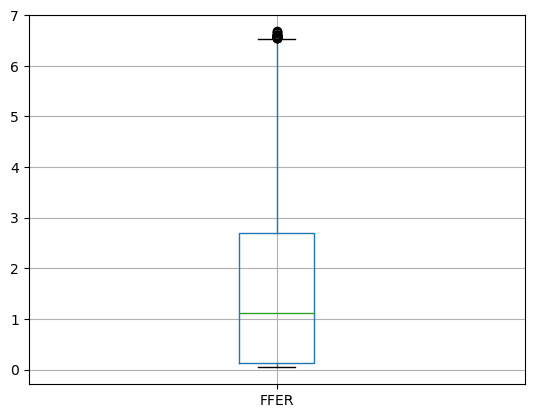

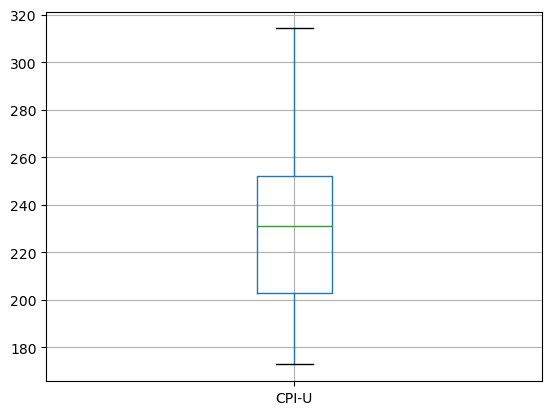

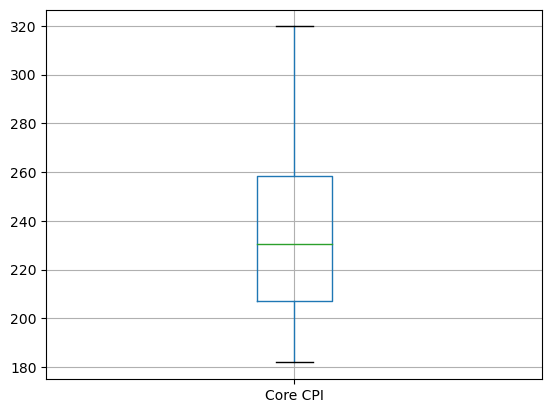

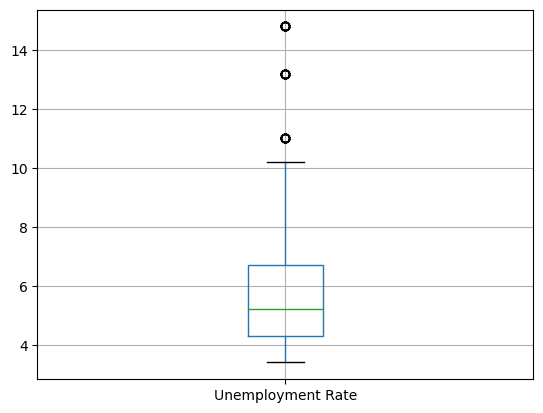

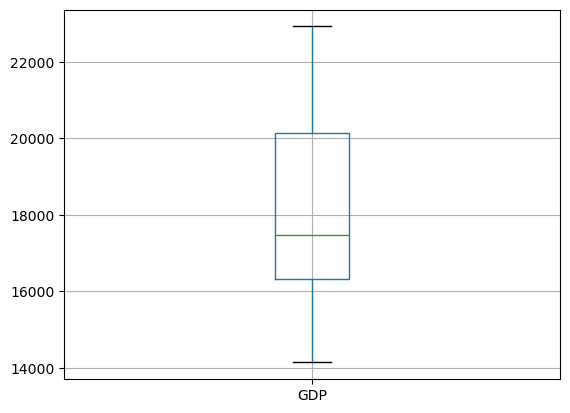

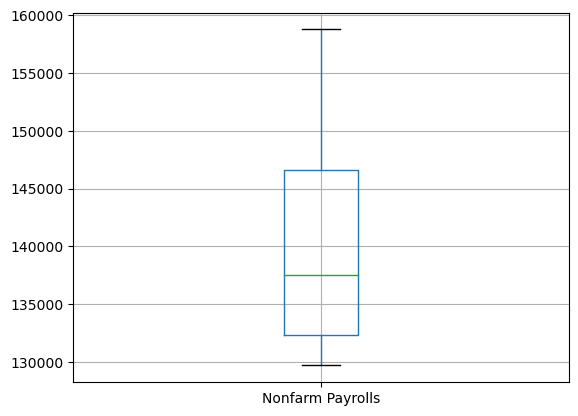

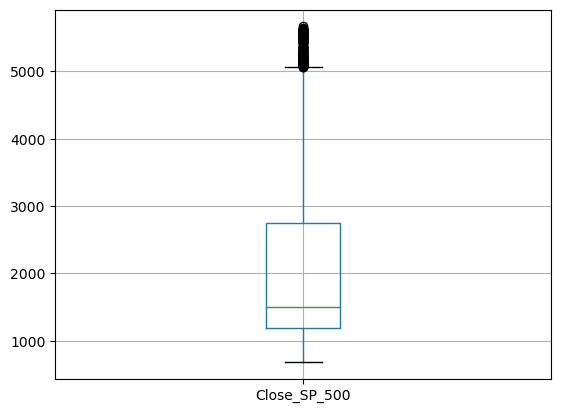

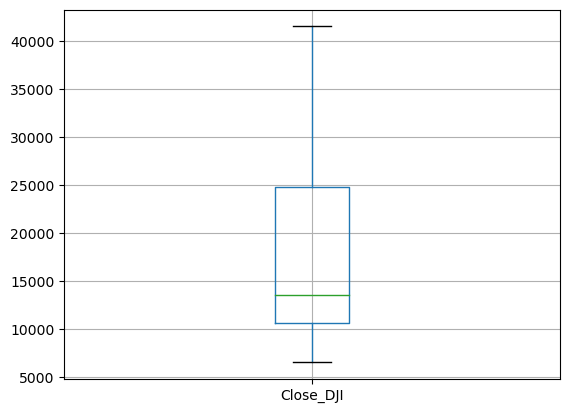

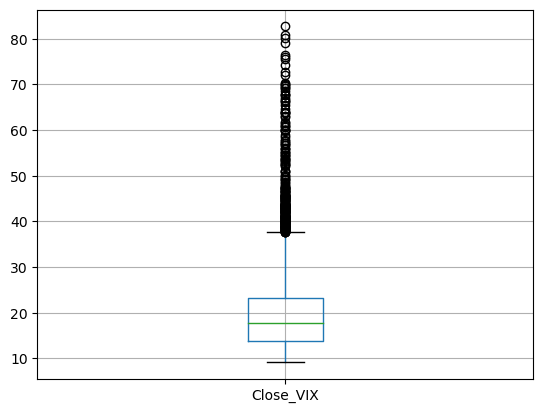

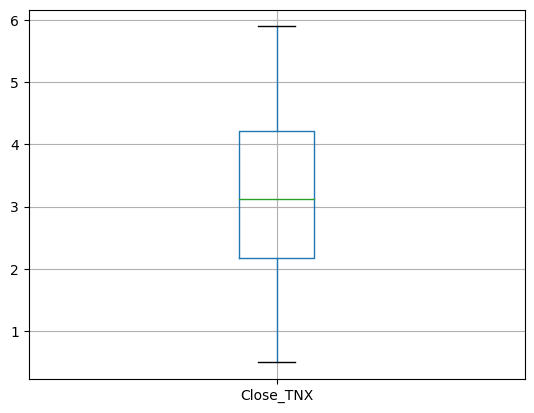

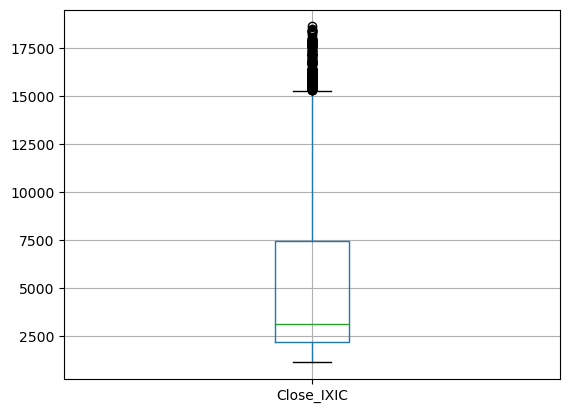

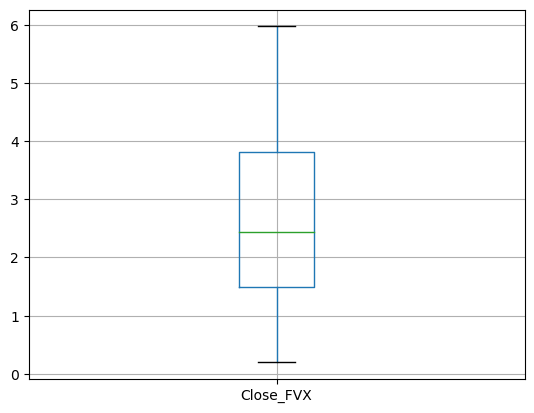

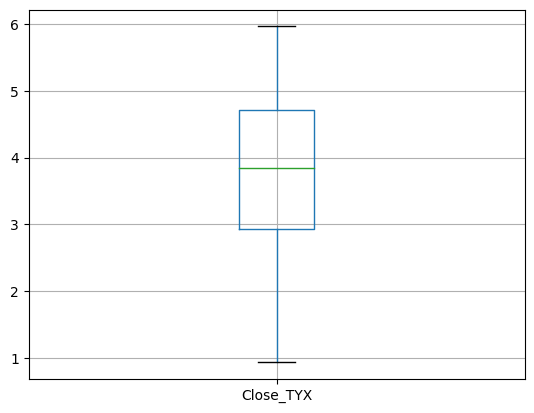

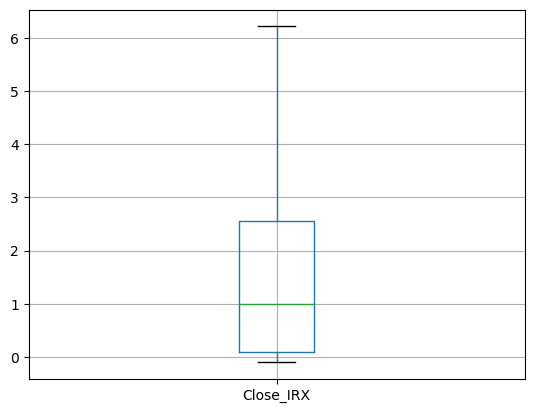

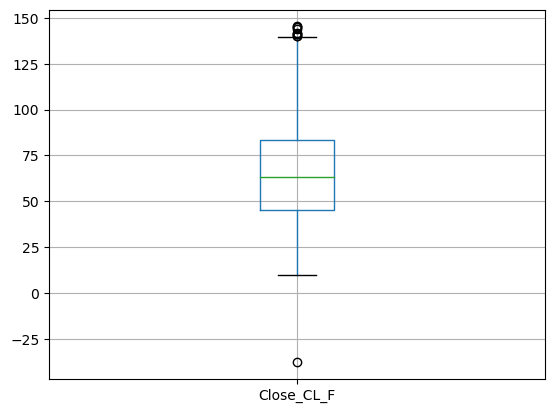

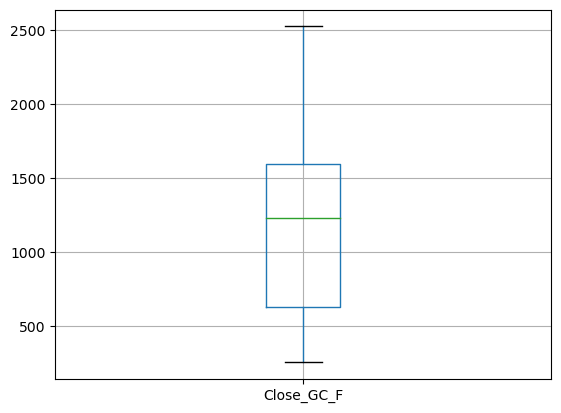

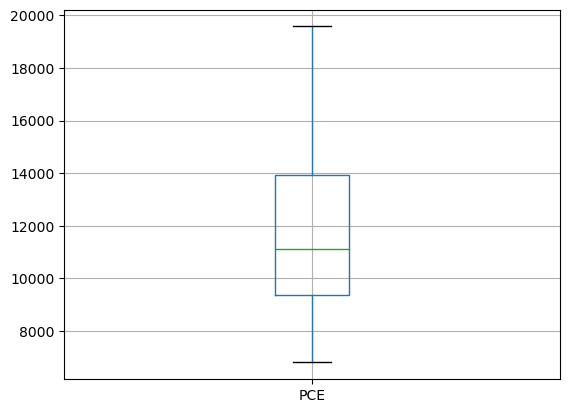

In [156]:
cols = ['FFER', 'CPI-U', 'Core CPI', 'Unemployment Rate', 'GDP',
       'Nonfarm Payrolls', 'Close_SP_500', 'Close_DJI', 'Close_VIX',
       'Close_TNX', 'Close_IXIC', 'Close_FVX', 'Close_TYX', 'Close_IRX',
       'Close_CL_F', 'Close_GC_F', 'PCE']
for column in df_cleaned.columns:
    if column != 'Date':
        plt.figure()
        df_cleaned.boxplot(column)

#### FFER Outliers
Starting with the FFER, there are outliers around 7% but this was likely attributed to the late 1980s and the Federal Reserve was trying to combat inflation. This will be important for the model to learn that inflation is usually high in high interest rate environments. 

#### Unemployment Rate Outlier
Unemployment rate is another feature with outliers that are due to recession in 2009, 1982, and 2020. All of these years were apart of some recession. 2009 was the Great Recession. In 1982, there was a severe recession that was caused by quantitative tightening (QT) to fight inflation. 2020 was the Covid-19 Pandemic that resulted in many job losses. 

#### S&P 500 Outliers
The S&P 500 also has some outliers existing above 5000 points. Surprisingly, the S&P 500 closed above 5,000 for the first time in history on February 9th, 2024. This could be due to many factors such as inflation slowly lowering, rumors about the Federal Reserve cutting interest rates, AI boom, and the magnificent seven still performing well.

#### VIX Outliers
The VIX contains outliers past 40. This is likely due to the volatilty, as the VIX is the volatiltiy/fear index. It measures the market's expectation of 30-day volatility. For example, there was fear in the market when Bank of Japan (BOJ) did a surprise interest rate hike in July/August making the VIX reach 60s. This was the highest it has been since the 2008 financial crisis. These outliers are also economically related. 

#### IXIC/Nasdaq Outliers
The IXIC, also called the Nasdaq composite index, closing prices of above 15,000 are considered outliers. For reference, the NASDAQ is currently (Oct 14th) sitting at 18,502.69. The increase could be due to the underlying securities performing really well. 

To deteremine the above analysis, the dates and the outliers will be reviewed below.

In [157]:
def find_outliers(df, column):
    """
    This function returns a DataFrame of outliers for the specified column.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine outliers using the 1.5*IQR rule
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Get the rows where the values are outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [158]:
# DataFrame to collect the results
outlier_dates = pd.DataFrame()
for column in df_cleaned.columns:
    if column != 'Date': 
        outliers = find_outliers(df_cleaned, column)
        if not outliers.empty:
            # Add the dates and the column name to the results DataFrame
            outlier_dates = pd.concat([outlier_dates, outliers[['Date']].assign(Column=column)], ignore_index=True)
outlier_dates
# Display the DataFrame containing all outlier dates and the corresponding column names

Date      Column
0   2000-08-31        FFER
1   2000-09-05        FFER
2   2000-09-06        FFER
3   2000-09-15        FFER
4   2000-09-28        FFER
..         ...         ...
651 2008-07-07  Close_CL_F
652 2008-07-10  Close_CL_F
653 2008-07-11  Close_CL_F
654 2008-07-14  Close_CL_F
655 2020-04-20  Close_CL_F

[656 rows x 2 columns]

In [159]:
#creates a year column by extracting it from Date
outlier_dates['Year'] = outlier_dates['Date'].dt.year

In [160]:
# Count the occurrences of outliers grouped by Year and Column
yearly_outlier_counts = outlier_dates.groupby(['Year', 'Column']).size().reset_index(name='Count')

In [161]:
yearly_outlier_counts.sort_values(by=['Column','Year'])

Year             Column  Count
4   2008         Close_CL_F      9
10  2020         Close_CL_F      1
13  2021         Close_IXIC     40
14  2022         Close_IXIC      2
15  2024         Close_IXIC    161
16  2024       Close_SP_500    129
1   2001          Close_VIX      6
3   2002          Close_VIX     21
5   2008          Close_VIX     64
6   2009          Close_VIX     73
7   2010          Close_VIX      4
8   2011          Close_VIX     19
9   2015          Close_VIX      1
11  2020          Close_VIX     40
17  2024          Close_VIX      1
0   2000               FFER     21
2   2001               FFER      1
12  2020  Unemployment Rate     63

After reviewing in more detail which years the outliers occurred in, here is the analysis. 

#### Close_CL_F, also Crude Oil
This feature has outliers in the years 2008 and 2020, the Great Recession and the Pandemic. Crude oil was impacted by both events, so thus these outliers are worth keeping so the model can learn from the economic change. 

#### Close_IXIC, also Nasdaq Composite 
Outliers were spotted in 2021, 2022, and 2024. Economic indicators could have impacted the volatility.

#### Close_SP_500
Outlier in 2024. Inflation, interest rate cuts, the Japan rate hike, payrolls, job reports, could have all impacted the S&P 500 this year. 

#### Close_VIX
Outliers in 2001, 2002, 2008-2011, 2015, 2020, and 2024. 

#### FFER
Outliers in 2000 and 2001. In Dec. of 2000, FFER was around 6% and then dropped in 2001 to 1.81% by the end of the year. 2001 was the Dot Com recession. 

#### Unemployment Rate
Outlier in 2020 attributed to the Pandemic. 

#### Conesus
Overall, it is determine that a lot of the outliers are attributed to changing economic status (recession, pandemic, QT to fight inflation). These outliers are important to understanding how certain economic factors can impact the Federal Funds Effective rate that the Federal Reserve sets. Thus, NO OUTLIERS WILL BE REMOVED. 


## Exploratory Data Analysis/Feature Engineering

In [162]:
#Extract year out of the date and make it its own column
df_cleaned['year'] = df_cleaned['Date'].dt.year
df_cleaned.sort_values('Date').head()

Date  FFER  CPI-U  Core CPI  Unemployment Rate        GDP  \
14853 2000-08-31  6.65  172.7     181.9                4.1  14145.312   
14854 2000-09-01  6.52  173.6     182.3                3.9  14145.312   
14858 2000-09-05  6.61  173.6     182.3                3.9  14145.312   
14859 2000-09-06  6.56  173.6     182.3                3.9  14145.312   
14860 2000-09-07  6.53  173.6     182.3                3.9  14145.312   

       Nonfarm Payrolls  Close_SP_500    Close_DJI  Close_VIX  Close_TNX  \
14853          132231.0   1517.680054  11215.09961  16.840000      5.729   
14854          132357.0   1520.770020  11238.78027  17.530001      5.675   
14858          132357.0   1507.079956  11260.61035  19.820000      5.683   
14859          132357.0   1492.250000  11310.63965  20.790001      5.712   
14860          132357.0   1502.510010  11259.87012  19.420000      5.749   

        Close_IXIC  Close_FVX  Close_TYX  Close_IRX  Close_CL_F  Close_GC_F  \
14853  4206.350098      5.975      5.674       6.11   33.099998  278.299988   
14854  4234.330078      5.891      5.655       6.08   33.380001  277.000000   
14858  4143.180176      5.905      5.663       6.06   33.799999  275.799988   
14859  4013.340088      5.927      5.700       6.01   34.950001  274.200012   
14860  4098.350098      5.957      5.713       6.00   35.330002  274.000000   

          PCE  year  
14853  6802.8  2000  
14854  6888.6  2000  
14858  6888.6  2000  
14859  6888.6  2000  
14860  6888.6  2000

In [163]:
df_cleaned['Date'].min()

Timestamp('2000-08-31 00:00:00')

In [164]:
df_cleaned['Date'].max()

Timestamp('2024-09-11 00:00:00')

In [165]:
#Number of observations per year
df_cleaned.groupby('year').count()

Date  FFER  CPI-U  Core CPI  Unemployment Rate  GDP  Nonfarm Payrolls  \
year                                                                          
2000    81    81     81        81                 81   81                81   
2001   244   244    244       244                244  244               244   
2002   248   248    248       248                248  248               248   
2003   248   248    248       248                248  248               248   
2004   247   247    247       247                247  247               247   
2005   246   246    246       246                246  246               246   
2006   246   246    246       246                246  246               246   
2007   249   249    249       249                249  249               249   
2008   251   251    251       251                251  251               251   
2009   250   250    250       250                250  250               250   
2010   249   249    249       249                249  249               249   
2011   250   250    250       250                250  250               250   
2012   248   248    248       248                248  248               248   
2013   250   250    250       250                250  250               250   
2014   250   250    250       250                250  250               250   
2015   250   250    250       250                250  250               250   
2016   250   250    250       250                250  250               250   
2017   249   249    249       249                249  249               249   
2018   248   248    248       248                248  248               248   
2019   250   250    250       250                250  250               250   
2020   251   251    251       251                251  251               251   
2021   248   248    248       248                248  248               248   
2022   249   249    249       249                249  249               249   
2023   248   248    248       248                248  248               248   
2024   175   175    175       175                175  175               175   

      Close_SP_500  Close_DJI  Close_VIX  Close_TNX  Close_IXIC  Close_FVX  \
year                                                                         
2000            81         81         81         81          81         81   
2001           244        244        244        244         244        244   
2002           248        248        248        248         248        248   
2003           248        248        248        248         248        248   
2004           247        247        247        247         247        247   
2005           246        246        246        246         246        246   
2006           246        246        246        246         246        246   
2007           249        249        249        249         249        249   
2008           251        251        251        251         251        251   
2009           250        250        250        250         250        250   
2010           249        249        249        249         249        249   
2011           250        250        250        250         250        250   
2012           248        248        248        248         248        248   
2013           250        250        250        250         250        250   
2014           250        250        250        250         250        250   
2015           250        250        250        250         250        250   
2016           250        250        250        250         250        250   
2017           249        249        249        249         249        249   
2018           248        248        248        248         248        248   
2019           250        250        250        250         250        250   
2020           251        251        251        251         251        251   
2021           248        248        248        248         248        248   


In [166]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5975 entries, 14853 to 23630
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               5975 non-null   datetime64[ns]
 1   FFER               5975 non-null   float64       
 2   CPI-U              5975 non-null   float64       
 3   Core CPI           5975 non-null   float64       
 4   Unemployment Rate  5975 non-null   float64       
 5   GDP                5975 non-null   float64       
 6   Nonfarm Payrolls   5975 non-null   float64       
 7   Close_SP_500       5975 non-null   float64       
 8   Close_DJI          5975 non-null   float64       
 9   Close_VIX          5975 non-null   float64       
 10  Close_TNX          5975 non-null   float64       
 11  Close_IXIC         5975 non-null   float64       
 12  Close_FVX          5975 non-null   float64       
 13  Close_TYX          5975 non-null   float64       
 14  Clo

In [167]:
df_cleaned.describe().T

count           mean          std            min  \
FFER               5975.0       1.764331     1.906853       0.040000   
CPI-U              5975.0     230.596572    36.306437     172.700000   
Core CPI           5975.0     235.631509    35.573242     181.900000   
Unemployment Rate  5975.0       5.765941     1.972549       3.400000   
GDP                5975.0   18054.852591  2471.881768   14145.312000   
Nonfarm Payrolls   5975.0  139738.628954  8385.143143  129702.000000   
Close_SP_500       5975.0    2085.122521  1190.449555     676.530029   
Close_DJI          5975.0   17864.501348  9037.798633    6547.049805   
Close_VIX          5975.0      19.822117     8.582637       9.140000   
Close_TNX          5975.0       3.176066     1.225672       0.499000   
Close_IXIC         5975.0    5333.744919  4311.167303    1114.109985   
Close_FVX          5975.0       2.594023     1.379496       0.195000   
Close_TYX          5975.0       3.784722     1.119901       0.937000   
Close_IRX          5975.0       1.641495     1.812245      -0.105000   
Close_CL_F         5975.0      64.628706    25.238661     -37.630001   
Close_GC_F         5975.0    1142.638008   558.939412     255.100006   
PCE                5975.0   11754.995749  3339.234653    6802.800000   
year               5975.0    2012.209540     6.936409    2000.000000   

                             25%            50%            75%            max  
FFER                    0.130000       1.110000       2.695000       6.680000  
CPI-U                 202.800000     231.015000     252.182000     314.121000  
Core CPI              207.200000     230.659000     258.368000     319.768000  
Unemployment Rate       4.300000       5.200000       6.700000      14.800000  
GDP                 16326.281000   17469.650000   20150.476000   22924.863000  
Nonfarm Payrolls   132357.000000  137492.000000  146588.000000  158779.000000  
Close_SP_500         1192.729981    1502.390015    2743.469971    5667.200195  
Close_DJI           10607.045410   13539.860350   24835.959965   41563.078130  
Close_VIX              13.760000      17.650000      23.300000      82.690002  
Close_TNX               2.168000       3.114000       4.205500       5.892000  
Close_IXIC           2172.265014    3104.959961    7421.754883   18647.449220  
Close_FVX               1.494500       2.431000       3.805000       5.975000  
Close_TYX               2.931000       3.838000       4.710000       5.962000  
Close_IRX               0.088000       0.998000       2.558500       6.220000  
Close_CL_F             45.490002      63.369999      83.174999     145.289993  
Close_GC_F            627.149994    1229.400024    1592.500000    2525.699951  
PCE                  9375.400000   11105.300000   13930.400000   19580.500000  
year                 2006.000000    2012.000000    2018.000000    2024.000000

In [168]:
df_cleaned.head()

Date  FFER  CPI-U  Core CPI  Unemployment Rate        GDP  \
14853 2000-08-31  6.65  172.7     181.9                4.1  14145.312   
14854 2000-09-01  6.52  173.6     182.3                3.9  14145.312   
14858 2000-09-05  6.61  173.6     182.3                3.9  14145.312   
14859 2000-09-06  6.56  173.6     182.3                3.9  14145.312   
14860 2000-09-07  6.53  173.6     182.3                3.9  14145.312   

       Nonfarm Payrolls  Close_SP_500    Close_DJI  Close_VIX  Close_TNX  \
14853          132231.0   1517.680054  11215.09961  16.840000      5.729   
14854          132357.0   1520.770020  11238.78027  17.530001      5.675   
14858          132357.0   1507.079956  11260.61035  19.820000      5.683   
14859          132357.0   1492.250000  11310.63965  20.790001      5.712   
14860          132357.0   1502.510010  11259.87012  19.420000      5.749   

        Close_IXIC  Close_FVX  Close_TYX  Close_IRX  Close_CL_F  Close_GC_F  \
14853  4206.350098      5.975      5.674       6.11   33.099998  278.299988   
14854  4234.330078      5.891      5.655       6.08   33.380001  277.000000   
14858  4143.180176      5.905      5.663       6.06   33.799999  275.799988   
14859  4013.340088      5.927      5.700       6.01   34.950001  274.200012   
14860  4098.350098      5.957      5.713       6.00   35.330002  274.000000   

          PCE  year  
14853  6802.8  2000  
14854  6888.6  2000  
14858  6888.6  2000  
14859  6888.6  2000  
14860  6888.6  2000

In [169]:
df_cleaned.shape

(5975, 19)

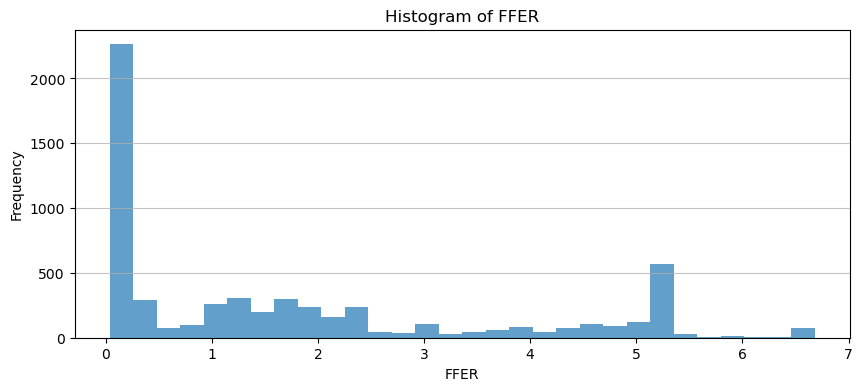

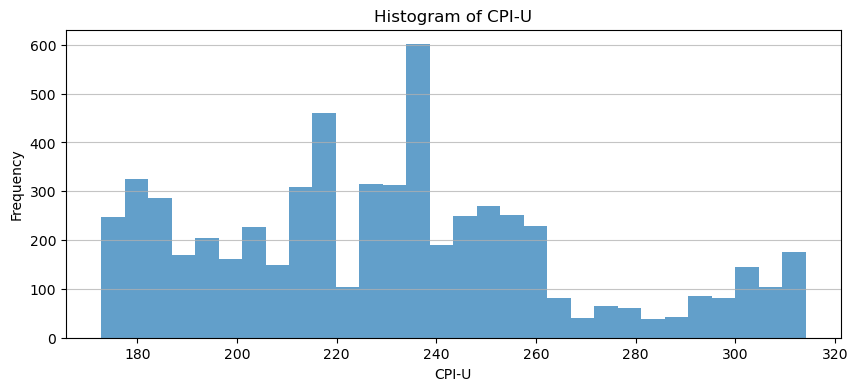

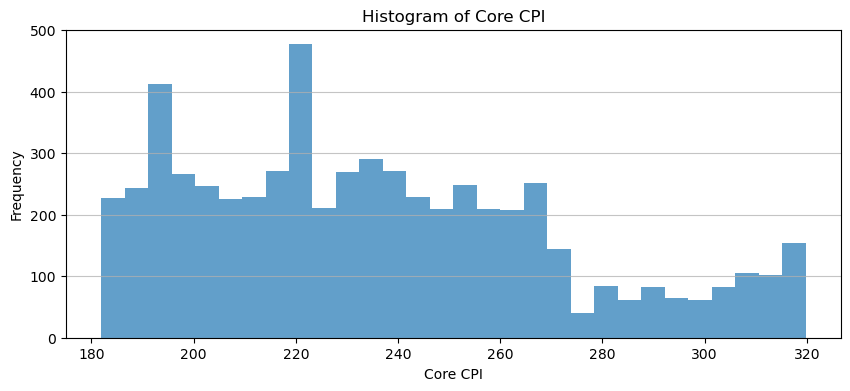

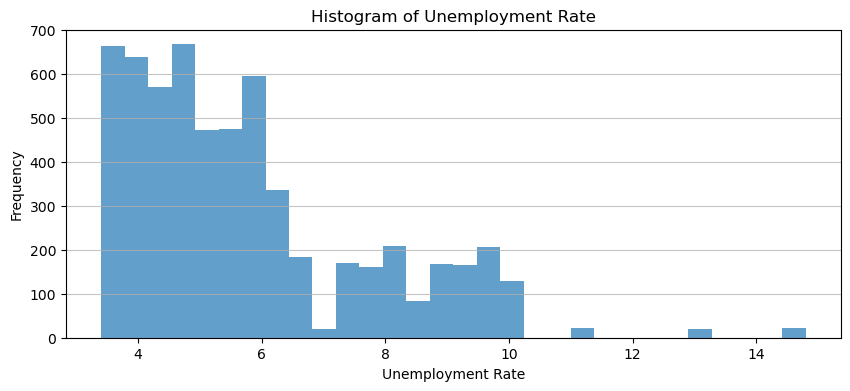

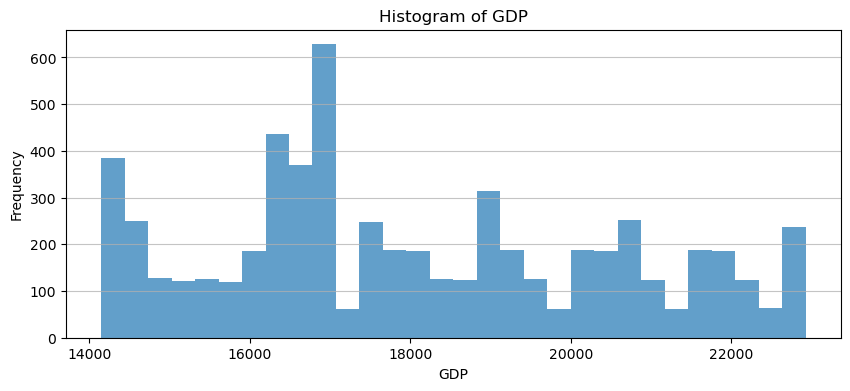

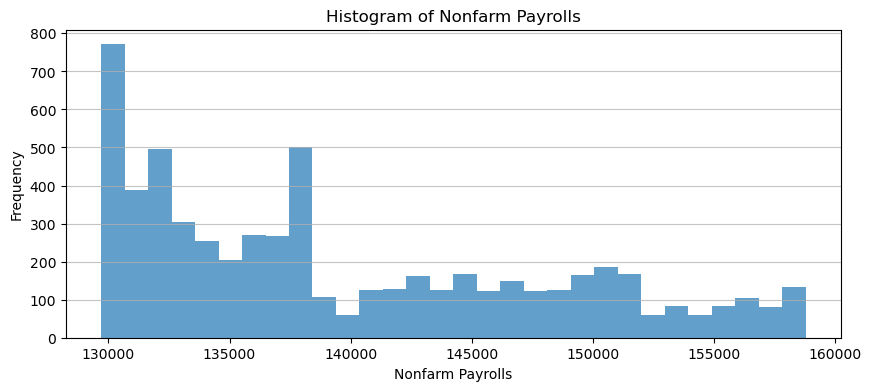

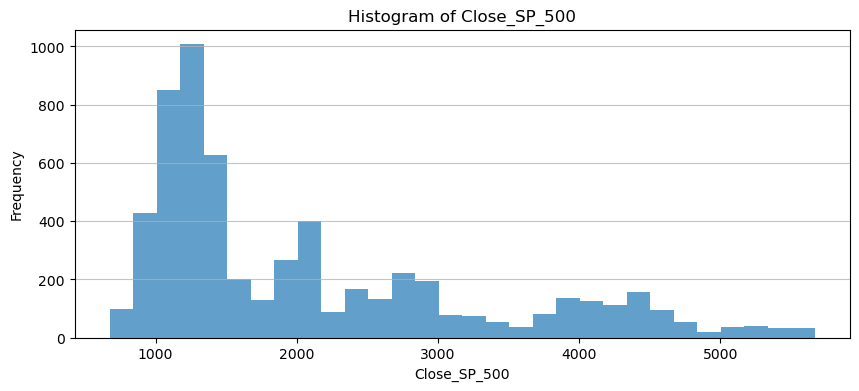

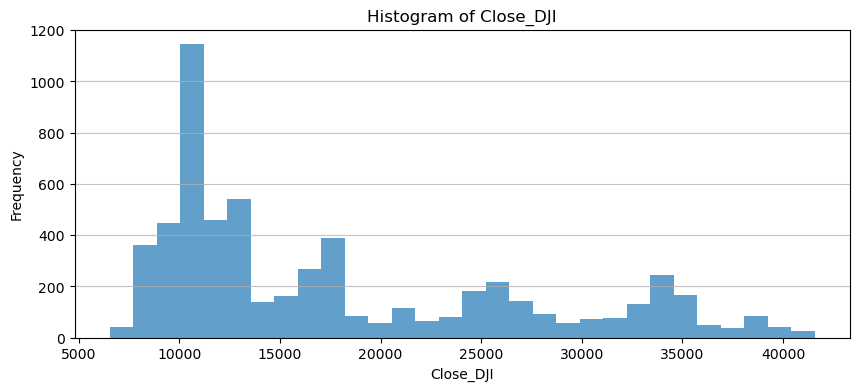

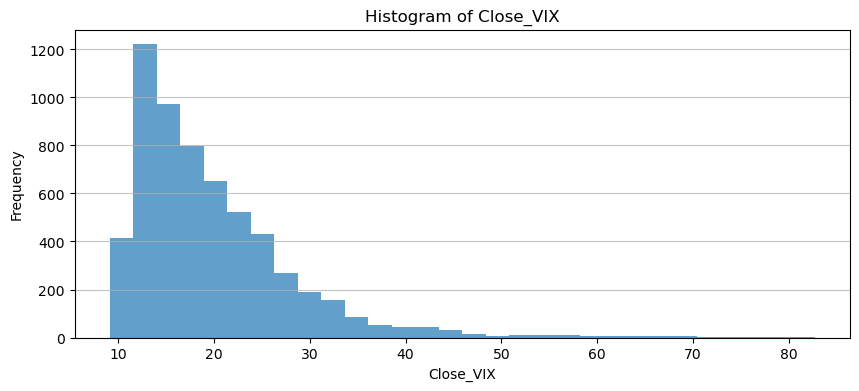

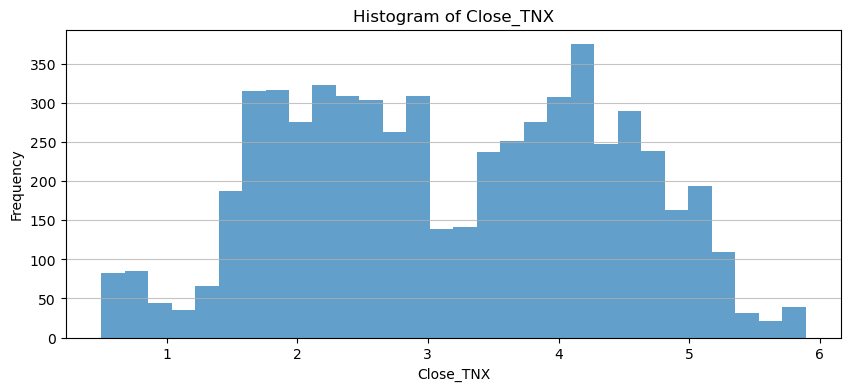

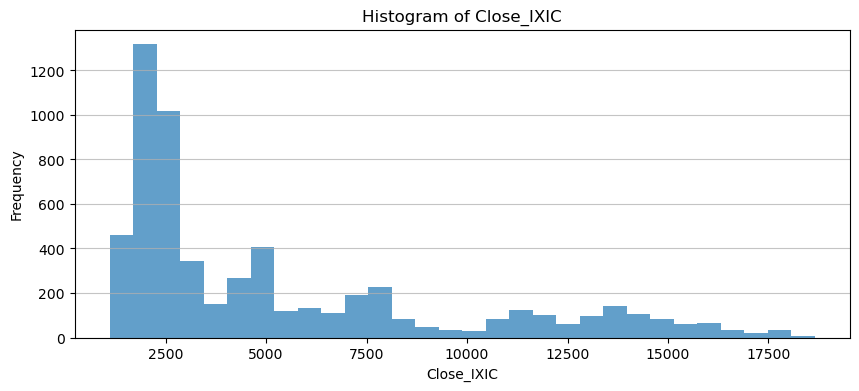

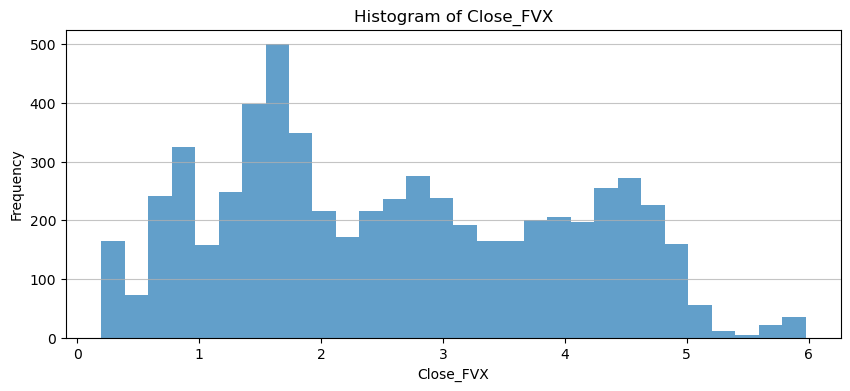

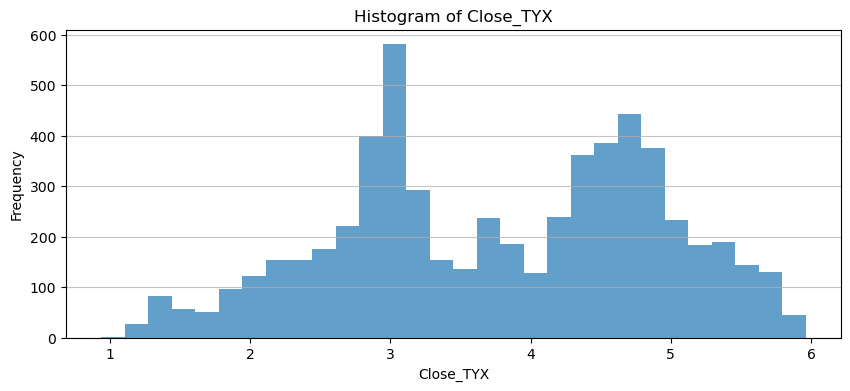

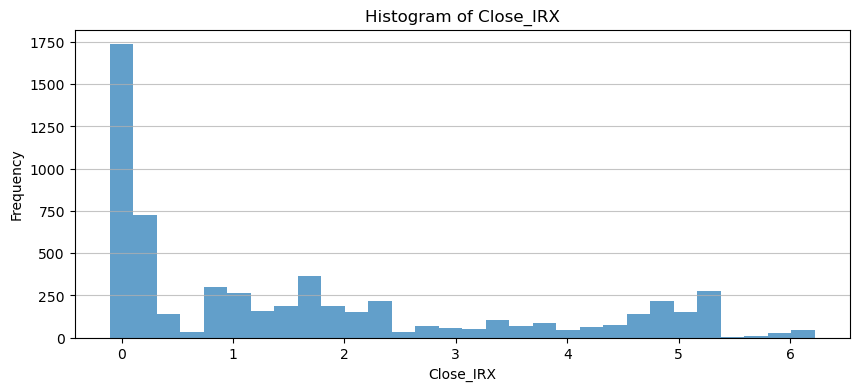

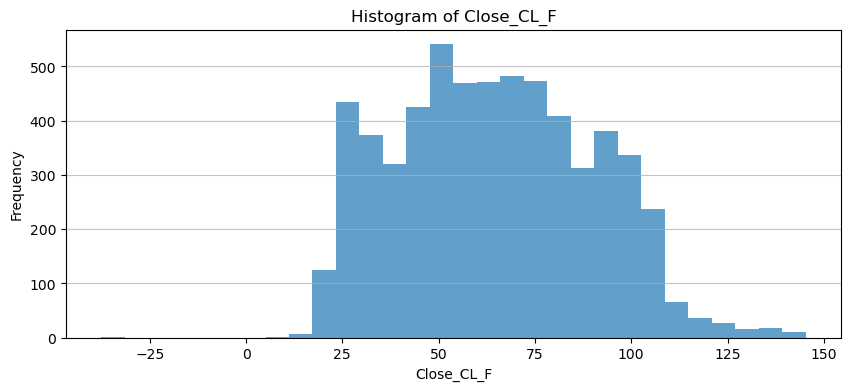

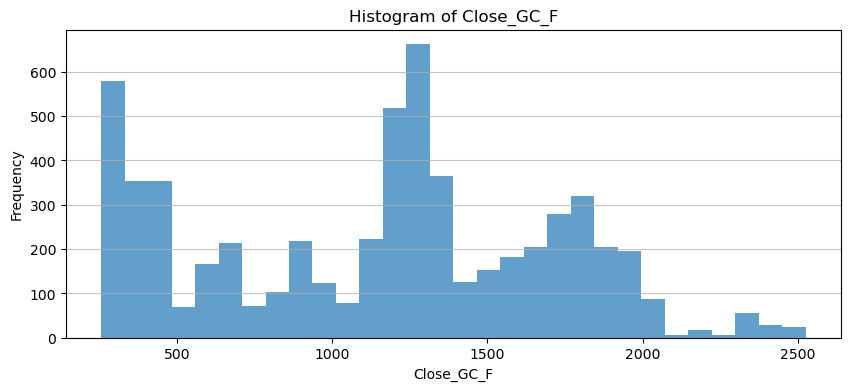

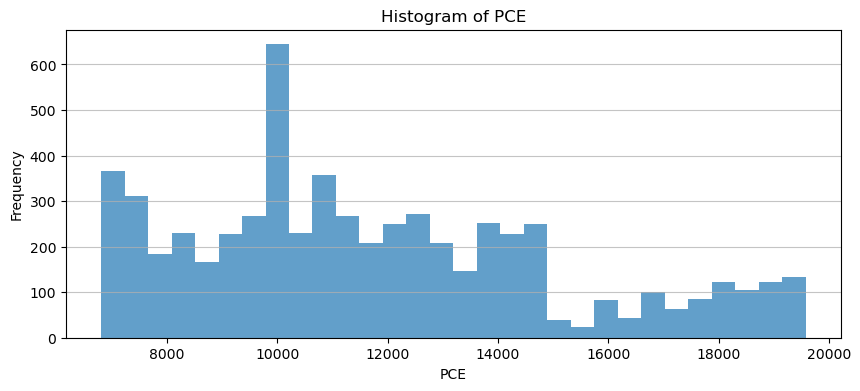

In [170]:
" This block of code prints the frequency for each feature, and so their distributions can be viewed"
for column in df_cleaned.columns:
    if column != 'Date' and column != 'year': 
        plt.figure(figsize=(10, 4))  # Set figure size for each histogram
        df_cleaned[column].plot.hist(bins=30, alpha=0.7)  # Adjust number of bins and transparency
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)  # Add grid for better readability
        plt.show()

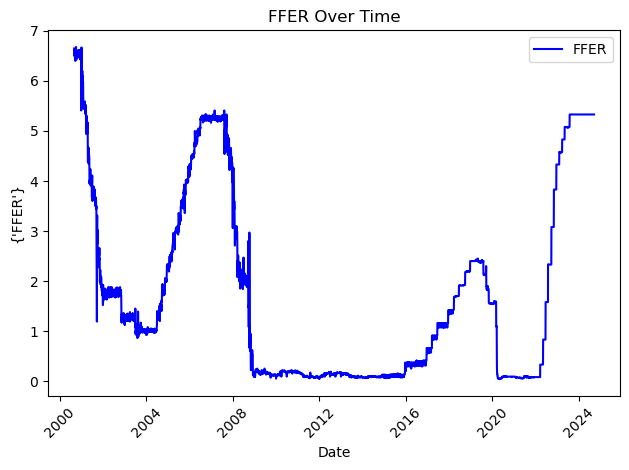

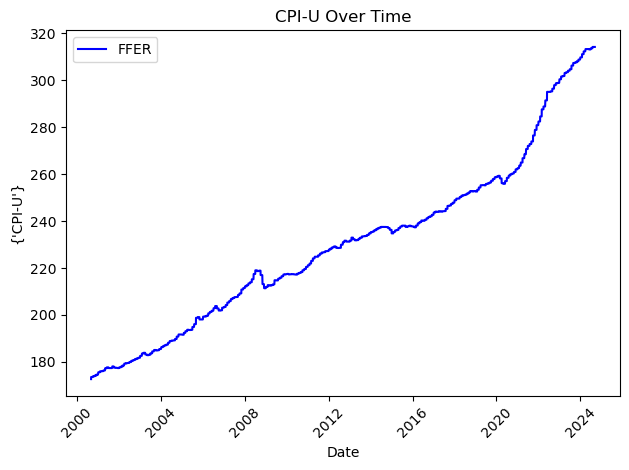

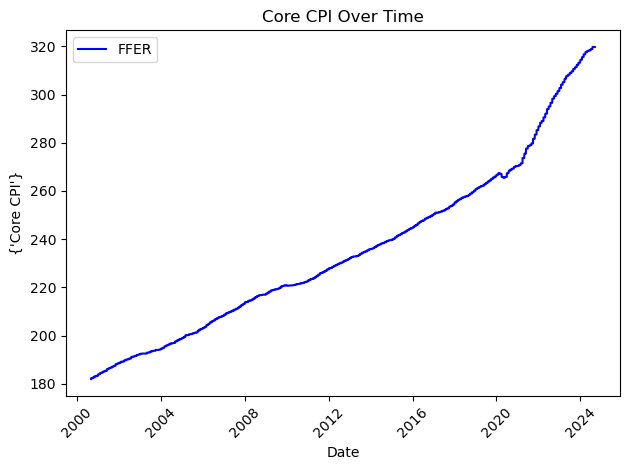

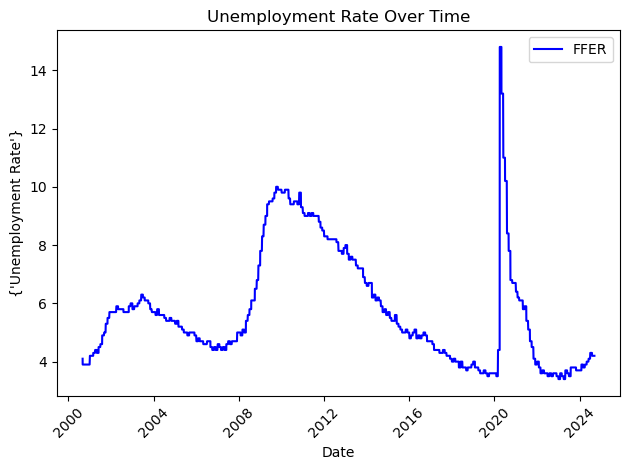

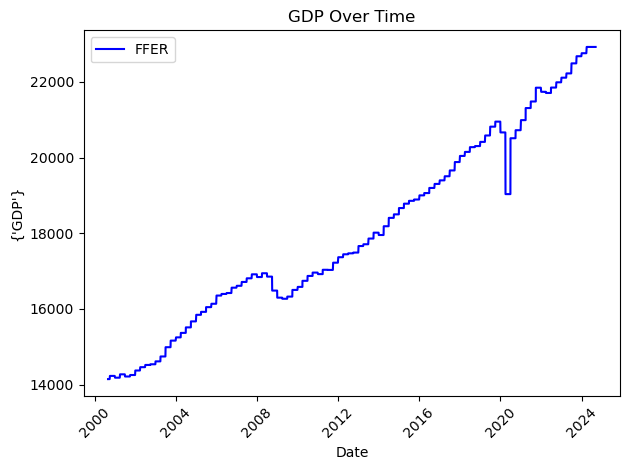

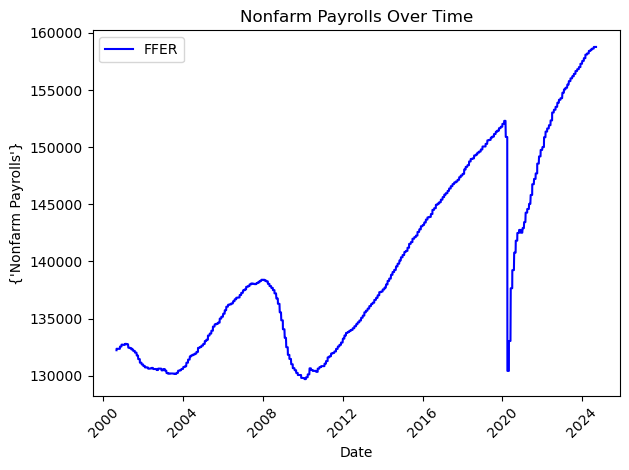

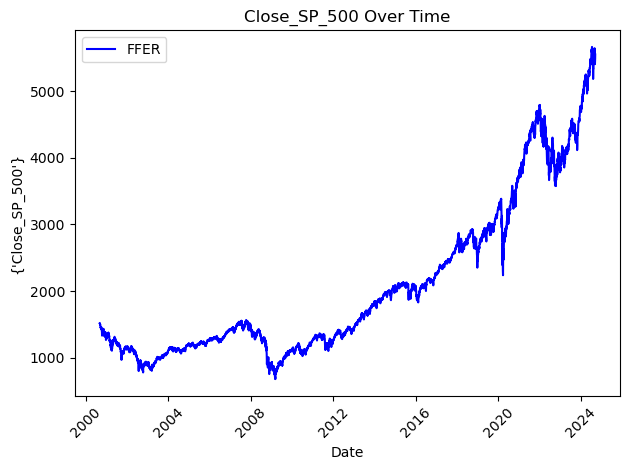

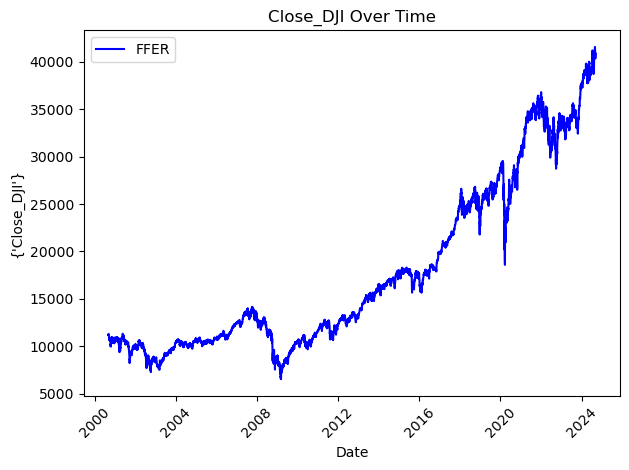

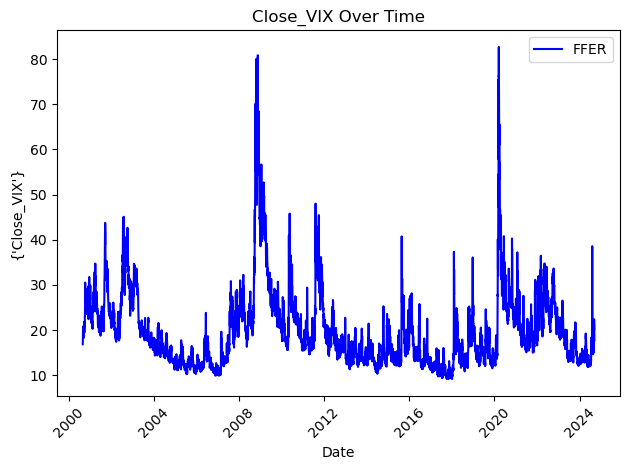

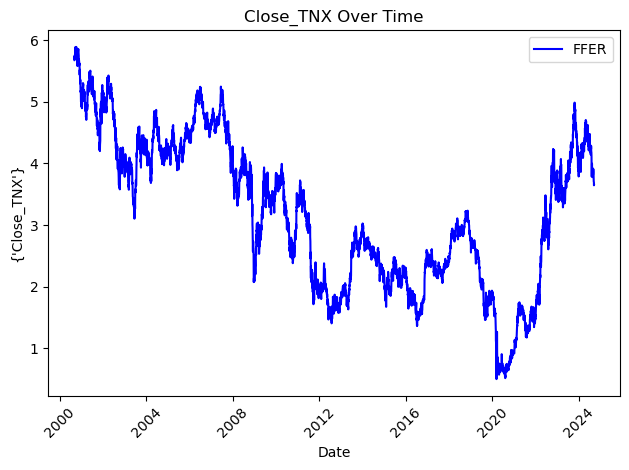

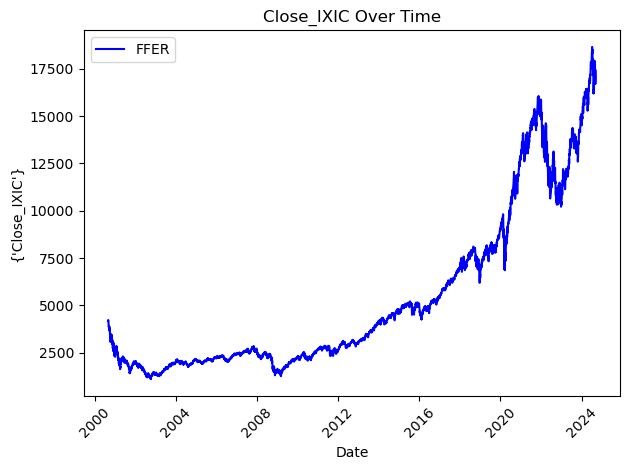

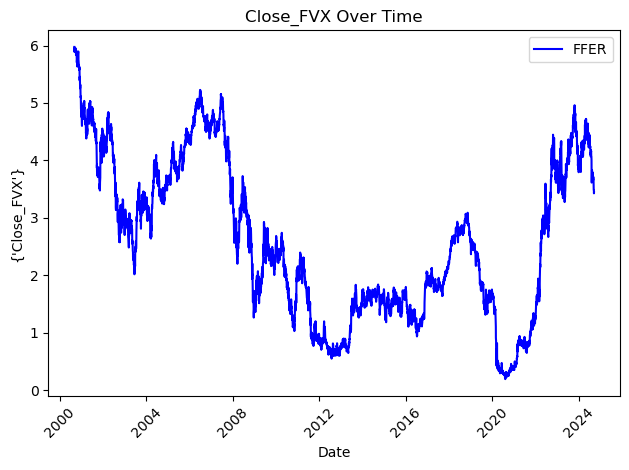

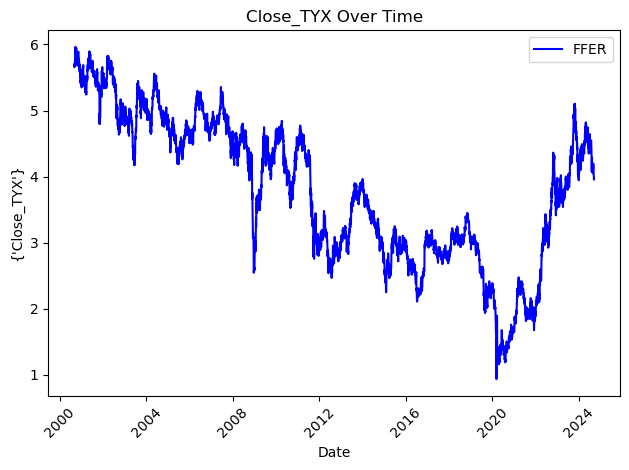

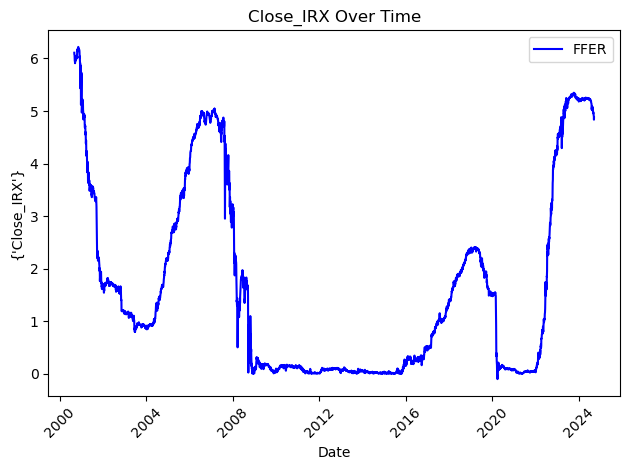

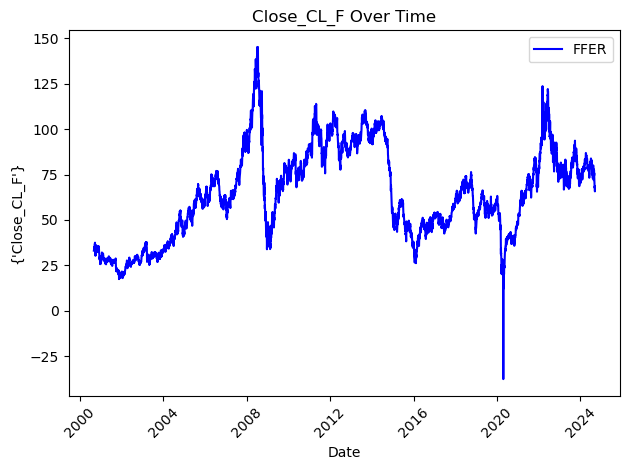

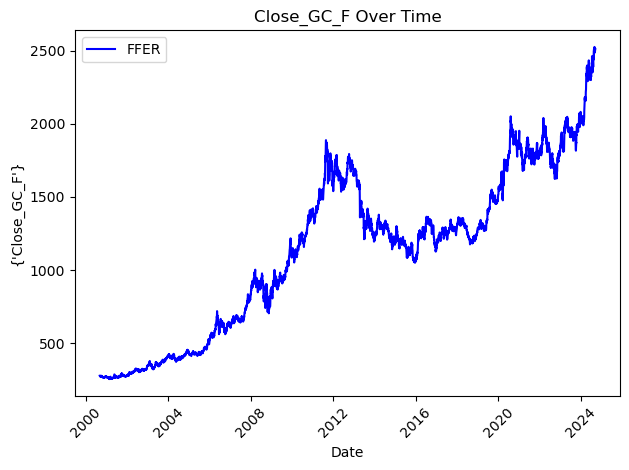

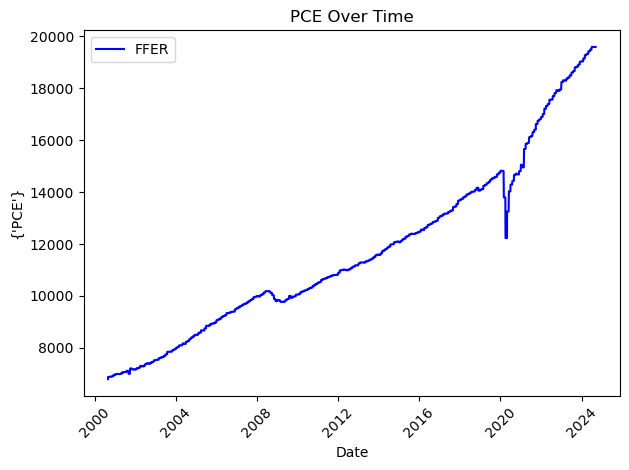

In [171]:
for column in df_cleaned.columns:
    if column != 'Date' and column != 'year': 
        sns.lineplot(x='Date', y=column, data=df_cleaned, color='blue', label='FFER')
        plt.title(f'{column} Over Time')
        plt.xlabel('Date')
        plt.ylabel({column})
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.tight_layout()  # Adjust layout
        plt.legend()
        plt.show()

By looking at the graphs of FFER, it resembles the years before the 2008 financial crisis. Inflation has continuously increased. The unemployment rates are very low right now, but it appears there is a slight increase in 2024. A lot of these features dropped in 2020, excluding the VIX. This makes me think most of these would be positively correlated. 

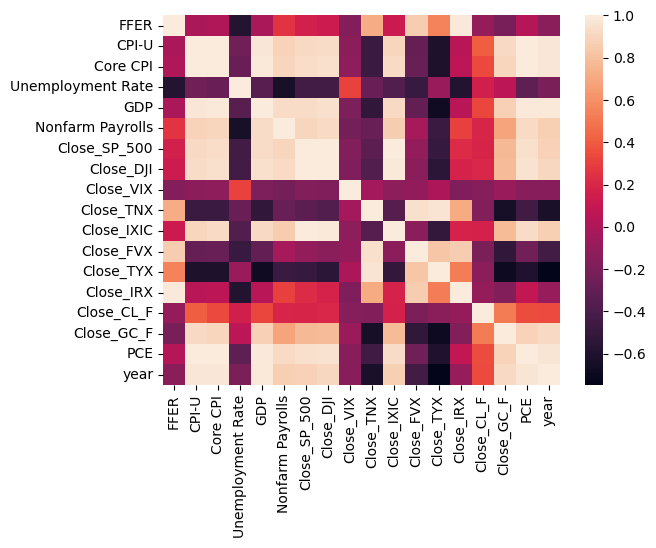

In [172]:
#correlations of each feature
_ = sns.heatmap(df_cleaned.corr())

In [173]:
type(df_cleaned)

pandas.core.frame.DataFrame

In [174]:
#correlations represented numerically
df_cleaned.corr().sort_values('FFER', ascending=False)

FFER     CPI-U  Core CPI  Unemployment Rate       GDP  \
FFER               1.000000 -0.005429  0.004620          -0.578284 -0.006725   
Close_IRX          0.990075  0.049320  0.061223          -0.591390  0.045231   
Close_FVX          0.858594 -0.290218 -0.279381          -0.484703 -0.304492   
Close_TNX          0.716016 -0.482267 -0.480490          -0.273905 -0.522653   
Close_TYX          0.548437 -0.612802 -0.617989          -0.073590 -0.673869   
Nonfarm Payrolls   0.253464  0.888235  0.903627          -0.638578  0.928465   
Close_SP_500       0.164979  0.916804  0.935835          -0.436152  0.927941   
Close_DJI          0.127655  0.927879  0.946799          -0.437047  0.948830   
Close_IXIC         0.123014  0.902832  0.923492          -0.375403  0.911482   
PCE                0.035103  0.993987  0.996755          -0.323610  0.988116   
Core CPI           0.004620  0.996113  1.000000          -0.274456  0.983999   
CPI-U             -0.005429  1.000000  0.996113          -0.246474  0.978952   
GDP               -0.006725  0.978952  0.983999          -0.343726  1.000000   
Close_CL_F        -0.098852  0.408502  0.332072           0.156912  0.326268   
year              -0.143928  0.973601  0.975637          -0.202123  0.982964   
Close_VIX         -0.164118 -0.127499 -0.124522           0.312090 -0.190159   
Close_GC_F        -0.214567  0.917241  0.898962           0.060327  0.872375   
Unemployment Rate -0.578284 -0.246474 -0.274456           1.000000 -0.343726   

                   Nonfarm Payrolls  Close_SP_500  Close_DJI  Close_VIX  \
FFER                       0.253464      0.164979   0.127655  -0.164118   
Close_IRX                  0.299107      0.216823   0.180254  -0.186211   
Close_FVX                 -0.027996     -0.102097  -0.147365  -0.109515   
Close_TNX                 -0.281618     -0.328383  -0.376961  -0.039680   
Close_TYX                 -0.479525     -0.499307  -0.547725   0.002164   
Nonfarm Payrolls           1.000000      0.903081   0.919571  -0.229363   
Close_SP_500               0.903081      1.000000   0.993600  -0.171245   
Close_DJI                  0.919571      0.993600   1.000000  -0.185210   
Close_IXIC                 0.863124      0.993924   0.984136  -0.122542   
PCE                        0.919839      0.945377   0.955917  -0.150951   
Core CPI                   0.903627      0.935835   0.946799  -0.124522   
CPI-U                      0.888235      0.916804   0.927879  -0.127499   
GDP                        0.928465      0.927941   0.948830  -0.190159   
Close_CL_F                 0.192584      0.186478   0.195303  -0.161050   
year                       0.865609      0.880221   0.907114  -0.148908   
Close_VIX                 -0.229363     -0.171245  -0.185210   1.000000   
Close_GC_F                 0.681746      0.773484   0.787173  -0.073381   
Unemployment Rate         -0.638578     -0.436152  -0.437047   0.312090   

                   Close_TNX  Close_IXIC  Close_FVX  Close_TYX  Close_IRX  \
FFER                0.716016    0.123014   0.858594   0.548437   0.990075   
Close_IRX           0.706786    0.174787   0.862595   0.528605   1.000000   
Close_FVX           0.948081   -0.139344   1.000000   0.825152   0.862595   
Close_TNX           1.000000   -0.353784   0.948081   0.959521   0.706786   
Close_TYX           0.959521   -0.513805   0.825152   1.000000   0.528605   
Nonfarm Payrolls   -0.281618    0.863124  -0.027996  -0.479525   0.299107   
Close_SP_500       -0.328383    0.993924  -0.102097  -0.499307   0.216823   
Close_DJI          -0.376961    0.984136  -0.147365  -0.547725   0.180254   
Close_IXIC         -0.353784    1.000000  -0.139344  -0.513805   0.174787   
PCE                -0.454519    0.930993  -0.247475  -0.600474   0.091060   
Core CPI           -0.480490    0.923492  -0.279381  -0.617989   0.061223   
CPI-U              -0.482267    0.902832  -0.290218  -0.612802   0.049320   
GDP                -0.522653    0.911482  -0.304492  -0.673869   0.045231  

In [175]:
#Date has to be an index so that the x-axis are repsented as dates for the
#seasonal decomposition
df_cleaned.set_index('Date', inplace=True)

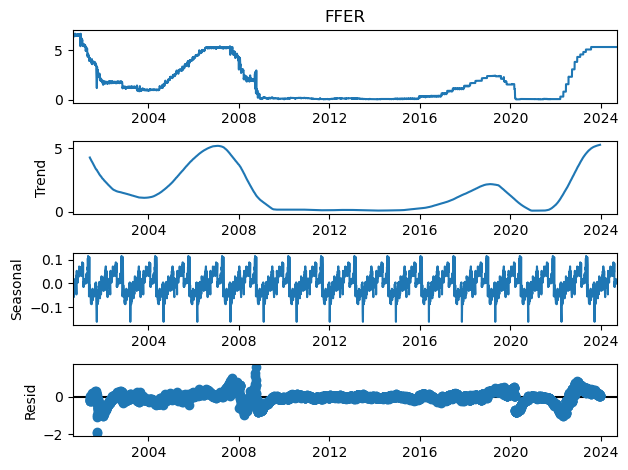

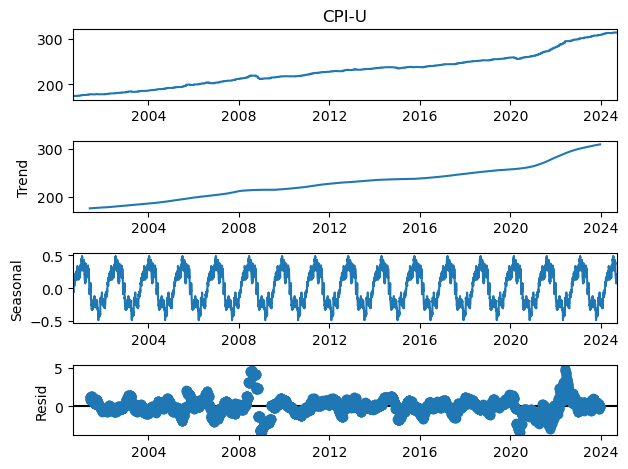

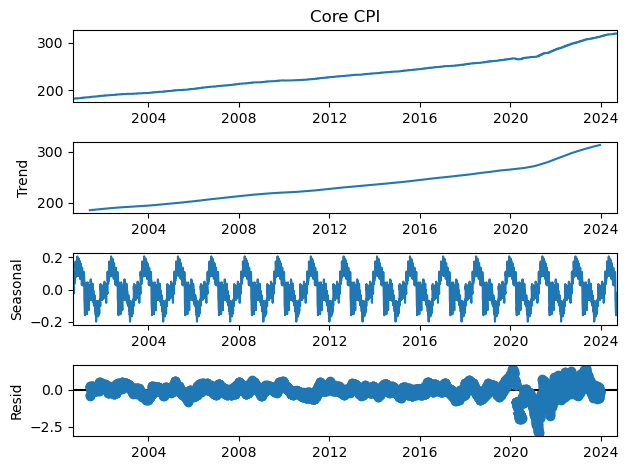

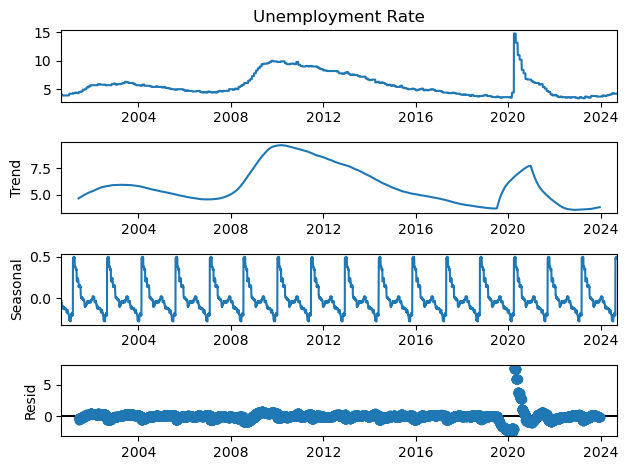

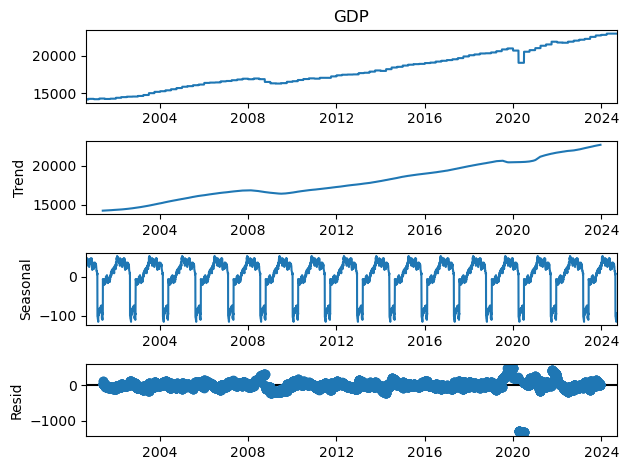

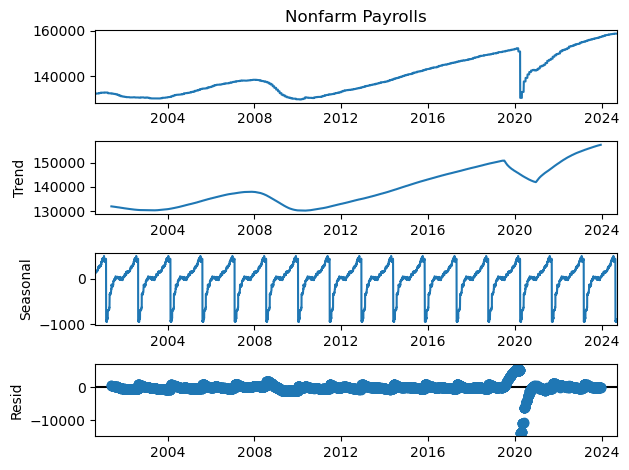

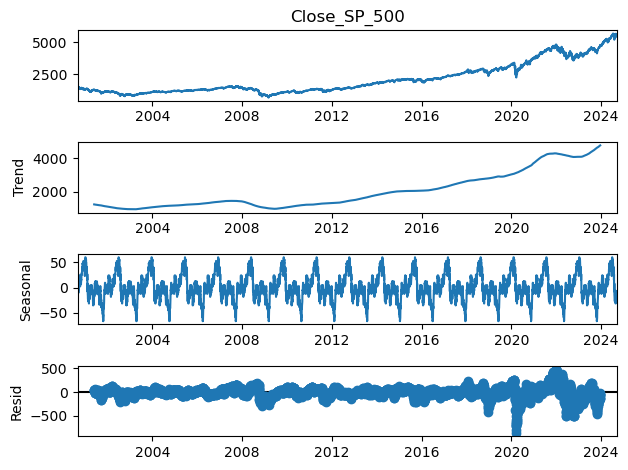

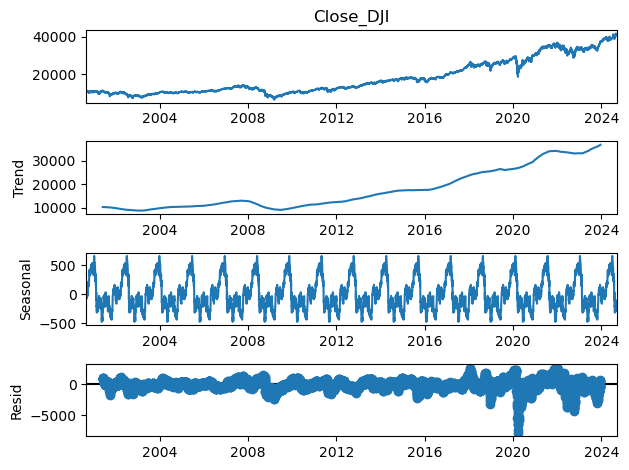

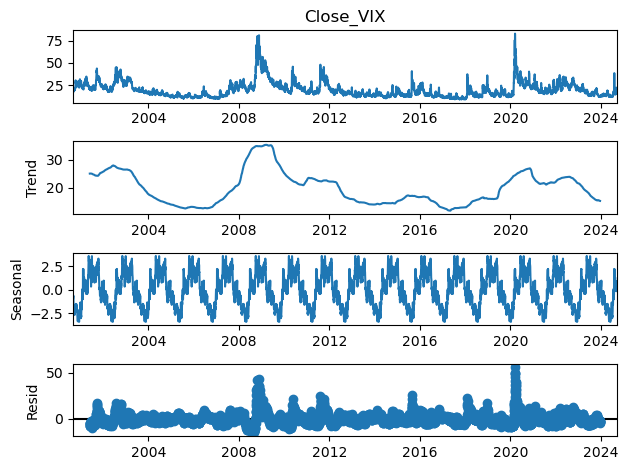

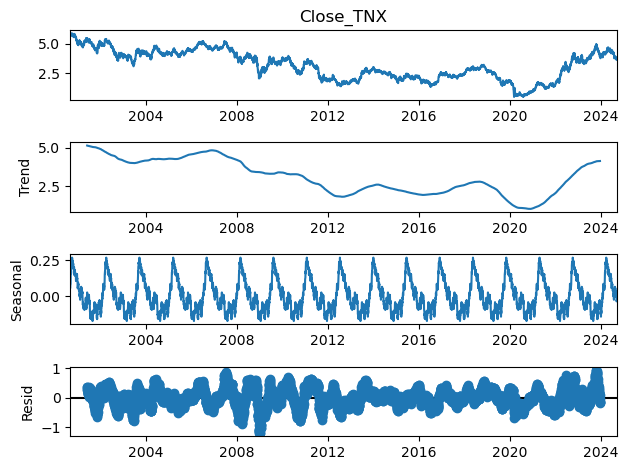

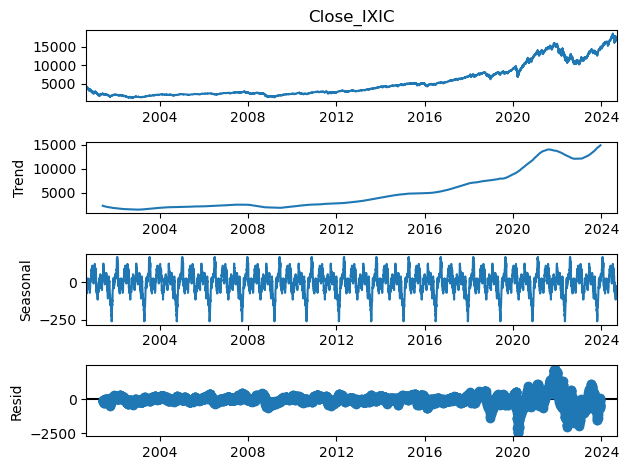

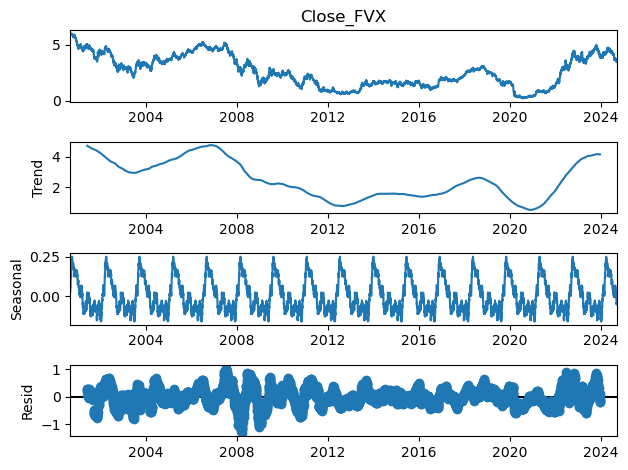

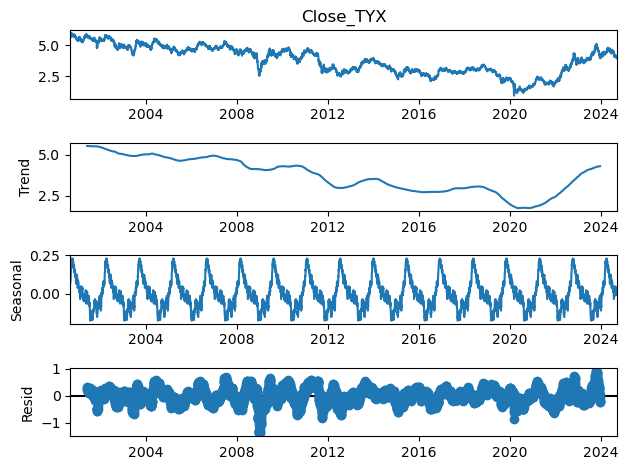

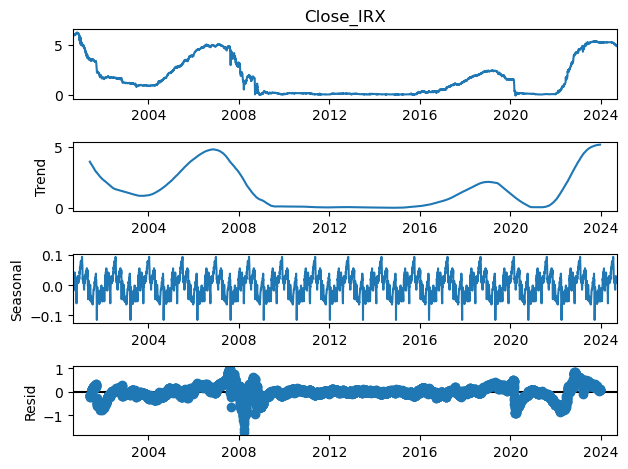

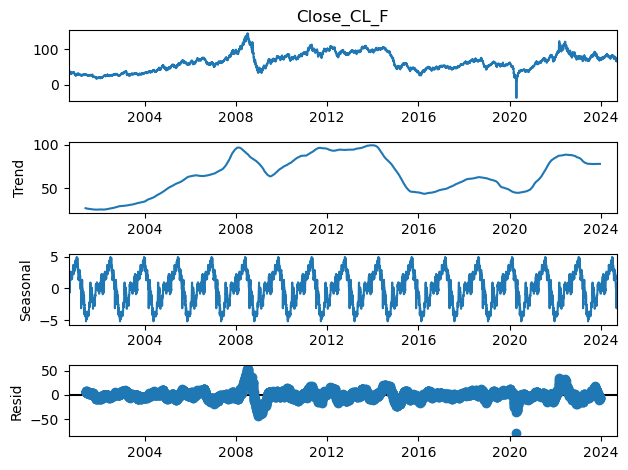

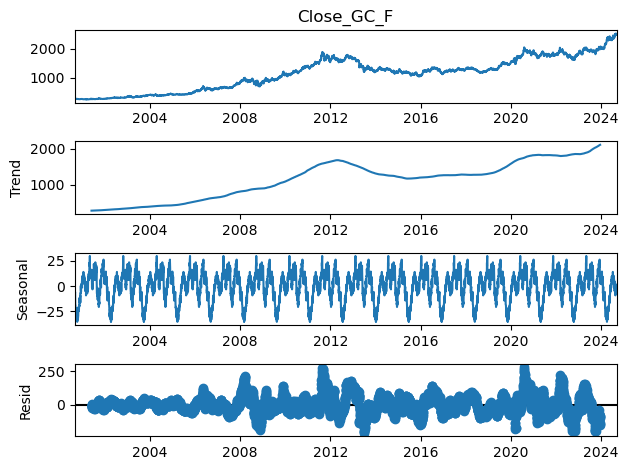

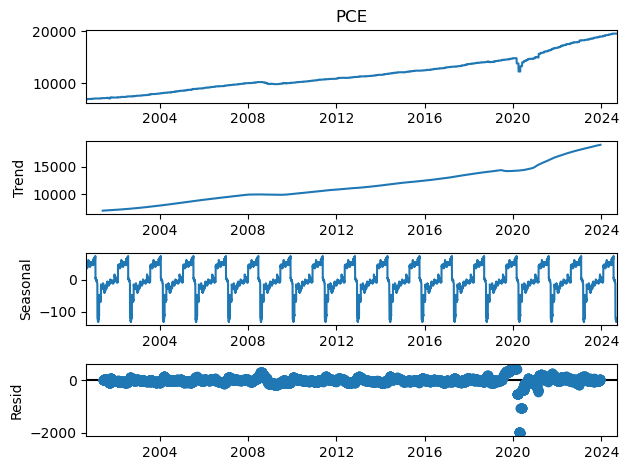

In [176]:
"""
Classical Time Series Decompositon: This breaks down time series data in to these parts: trend, seasonal,
residual. 

Trend: 
Trend captures the underlying behavior of the series. It neglects the short-term fluctuations, 
hence why the graph is so smooth.This shows the gradual changes in behavior over time. It can be determined 
if there exists a downward, flat, or upward trend.

Seasonality: 
This shows the recurring patterns over time, and occur at consistent time intervals. For example, the Santa Clause 
rally could be apart of this. Seasonality can be predictable and exhibit patterns in different time periods.

Residual: The residual component shows the random variations/noise that cannot be explained by a trend or 
seasonality. These are the unpredictable values. If there exists a pattern in this component, then a time series 
may not be the best model for the data. 
"""

for column in df_cleaned.columns:
    if column != 'Date' and column != 'year': 
        decomposition = seasonal_decompose(df_cleaned[column], model='additive', period=365)
        decomposition.plot()
        plt.show()

There exists seasonality amongst all features and the target value. This provides insight in to what model will be best to use. 

#### Upon further analysis, I want to know the following:
1. What were the highest and lowest values for each feature, and at what specific points in time did these extremes occur? What external factors impacted this, if any?
2. With the question: soft landing or recession in the air, how do all of the features and target compare to 1-3 years before 2008 and to the year before 2024?
3. How do the values of DJI, SPX, VIX, and TNX in December (Santa Clause rally) compare in the years 2018-2024? Are there consistent patterns?


In [177]:
#Question 1
results = []
for column in df_cleaned.columns:
    if column not in ['Date', 'year']:
        max_val = df_cleaned[column].max()
        min_val = df_cleaned[column].min()
       # Get the dates when the max value occurs
        max_dates = df_cleaned.index[df_cleaned[column] == max_val].date.tolist()
        min_dates = df_cleaned.index[df_cleaned[column] == min_val].date.tolist()

    # Append results as a dictionary
    results.append({
        'Column': column,
        'Max': max_val,
        'Max Date': max_dates,  # List of dates when max occurs
        'Min': min_val,
        'Min Date': min_dates   # List of dates when min occurs
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df

Column            Max  \
0                FFER       6.680000   
1               CPI-U     314.121000   
2            Core CPI     319.768000   
3   Unemployment Rate      14.800000   
4                 GDP   22924.863000   
5    Nonfarm Payrolls  158779.000000   
6        Close_SP_500    5667.200195   
7           Close_DJI   41563.078130   
8           Close_VIX      82.690002   
9           Close_TNX       5.892000   
10         Close_IXIC   18647.449220   
11          Close_FVX       5.975000   
12          Close_TYX       5.962000   
13          Close_IRX       6.220000   
14         Close_CL_F     145.289993   
15         Close_GC_F    2525.699951   
16                PCE   19580.500000   
17               year   19580.500000   

                                             Max Date            Min  \
0                                        [2000-10-02]       0.040000   
1   [2024-08-01, 2024-08-02, 2024-08-05, 2024-08-0...     172.700000   
2   [2024-08-01, 2024-08-02, 2024-08-05, 2024-08-0...     181.900000   
3   [2020-04-01, 2020-04-02, 2020-04-03, 2020-04-0...       3.400000   
4   [2024-04-01, 2024-04-02, 2024-04-03, 2024-04-0...   14145.312000   
5   [2024-08-01, 2024-08-02, 2024-08-05, 2024-08-0...  129702.000000   
6                                        [2024-07-16]     676.530029   
7                                        [2024-08-30]    6547.049805   
8                                        [2020-03-16]       9.140000   
9                            [2000-09-20, 2000-10-04]       0.499000   
10                                       [2024-07-10]    1114.109985   
11                                       [2000-08-31]       0.195000   
12                                       [2000-09-20]       0.937000   
13                           [2000-11-06, 2000-11-07]      -0.105000   
14                                       [2008-07-03]     -37.630001   
15                                       [2024-08-29]     255.100006   
16  [2024-07-01, 2024-07-02, 2024-07-03, 2024-07-0...    6802.800000   
17  [2024-07-01, 2024-07-02, 2024-07-03, 2024-07-0...    6802.800000   

                                             Min Date  
0   [2011-12-30, 2020-04-23, 2020-04-27, 2020-04-2...  
1                                        [2000-08-31]  
2                                        [2000-08-31]  
3   [2023-01-03, 2023-01-04, 2023-01-05, 2023-01-0...  
4   [2000-08-31, 2000-09-01, 2000-09-05, 2000-09-0...  
5   [2010-02-01, 2010-02-02, 2010-02-03, 2010-02-0...  
6                                        [2009-03-09]  
7                                        [2009-03-09]  
8                                        [2017-11-03]  
9                                        [2020-03-09]  
10                                       [2002-10-09]  
11                                       [2020-08-04]  
12                                       [2020-03-09]  
13                                       [2020-03-26]  
14                                       [2020-04-20]  
15                                       [2001-02-15]  
16                                       [2000-08-31]  
17                                       [2000-08-31]

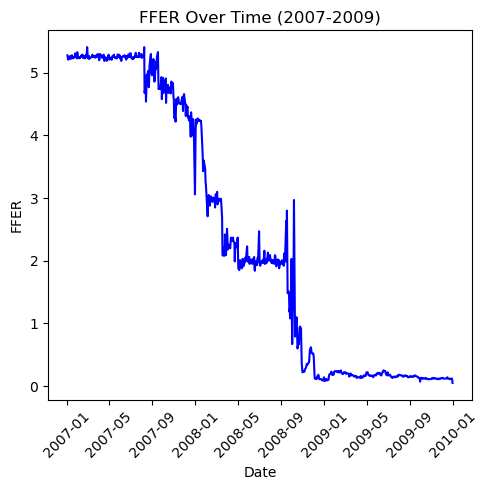

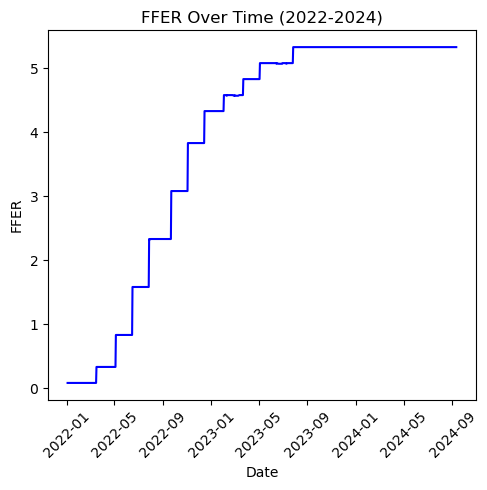

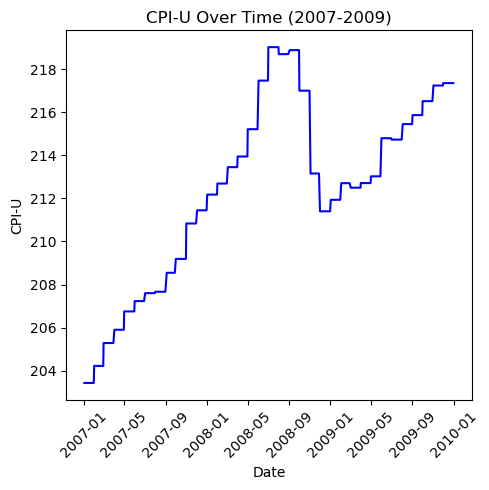

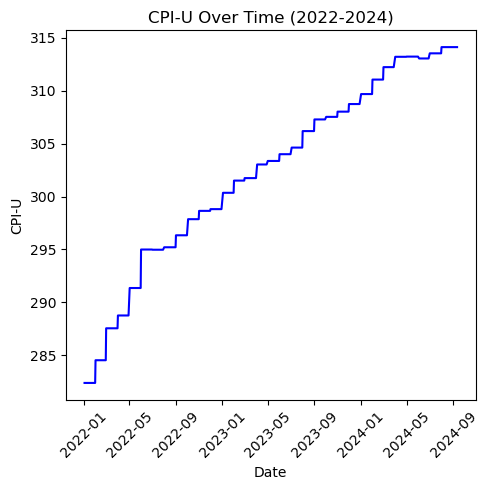

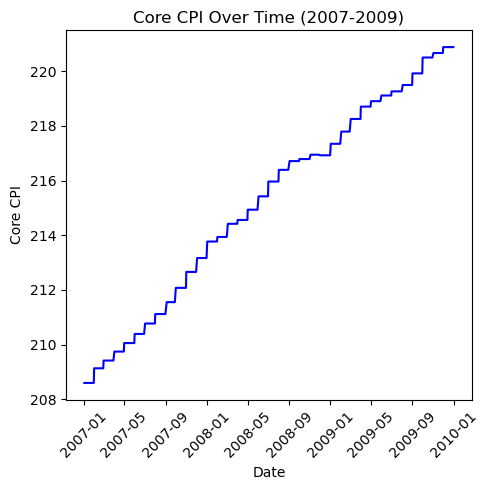

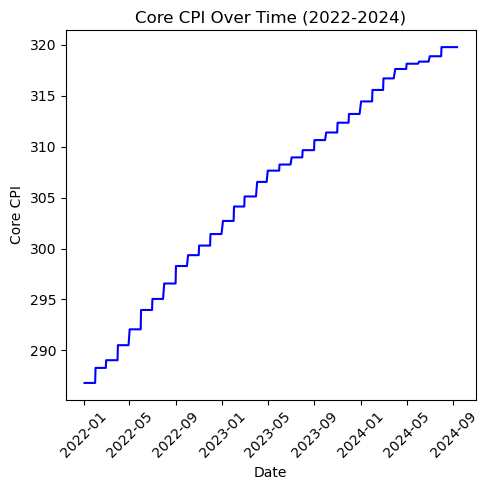

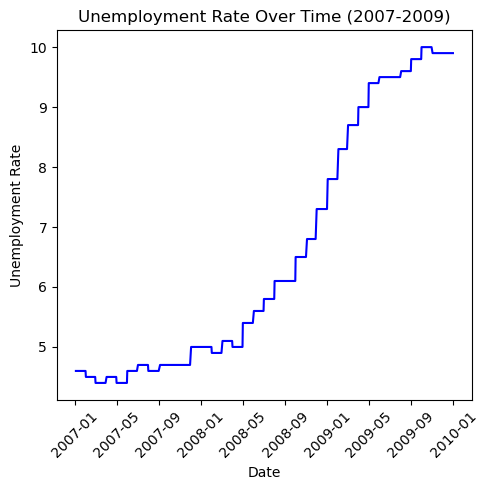

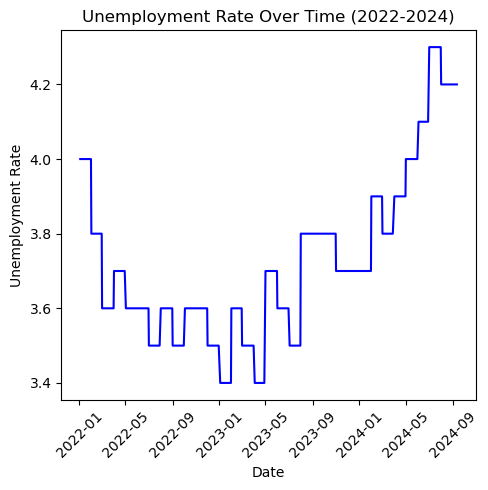

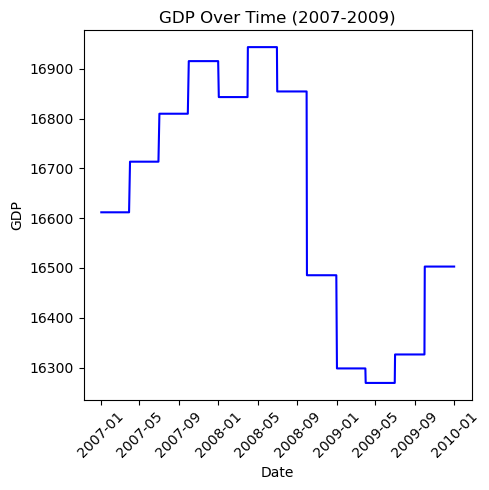

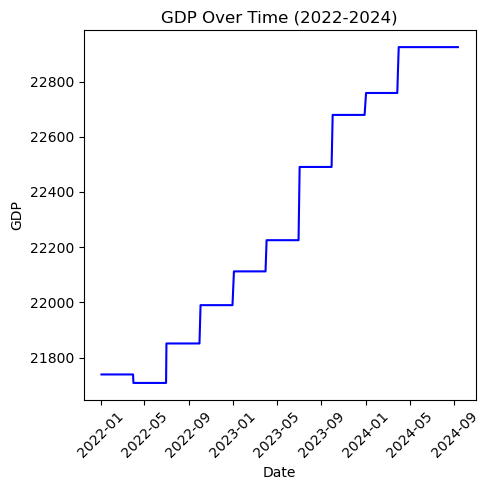

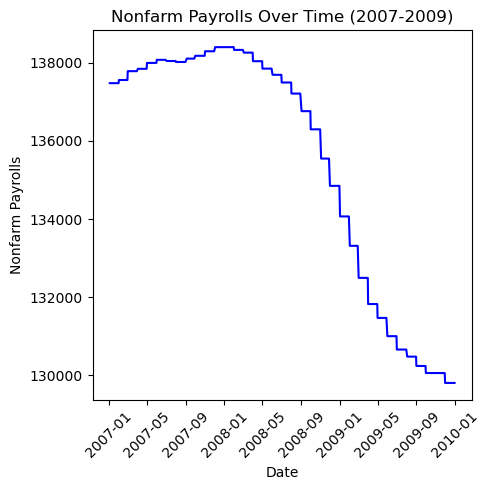

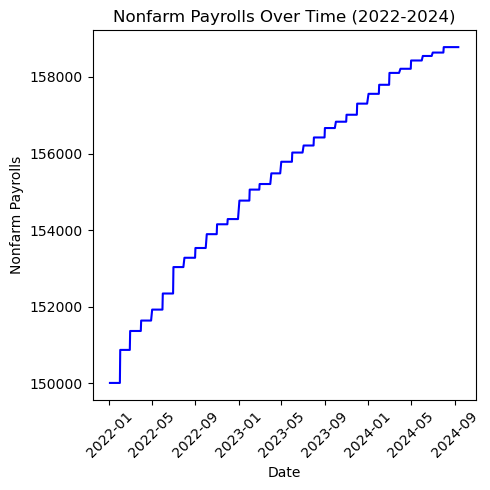

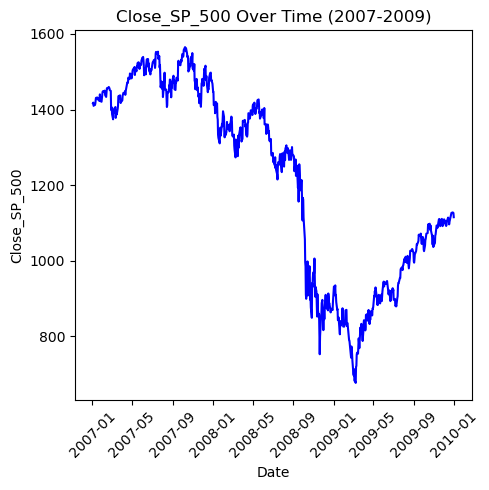

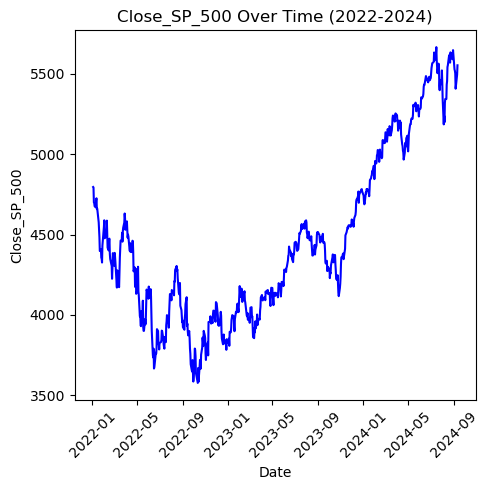

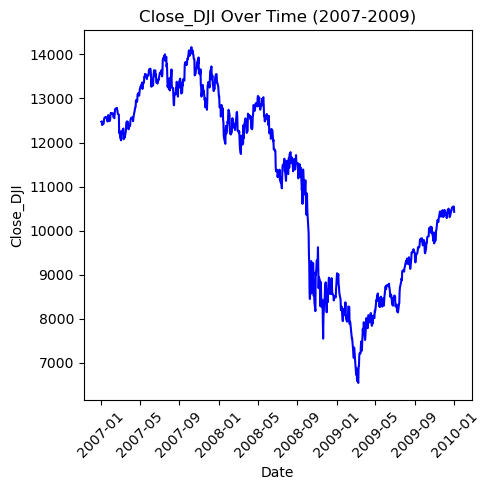

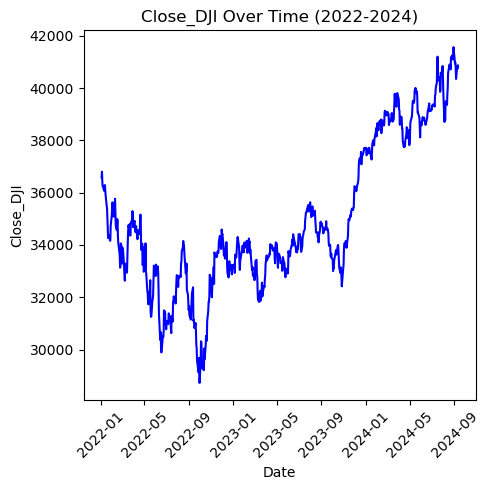

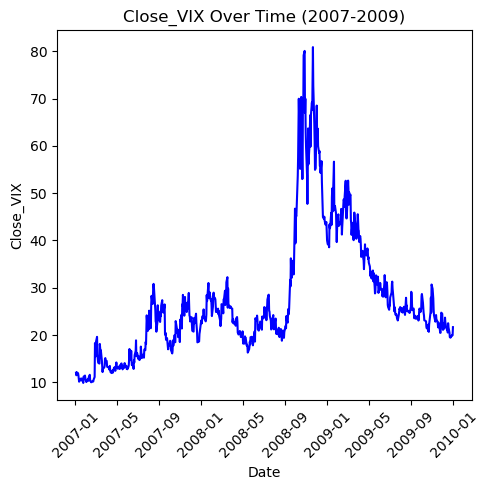

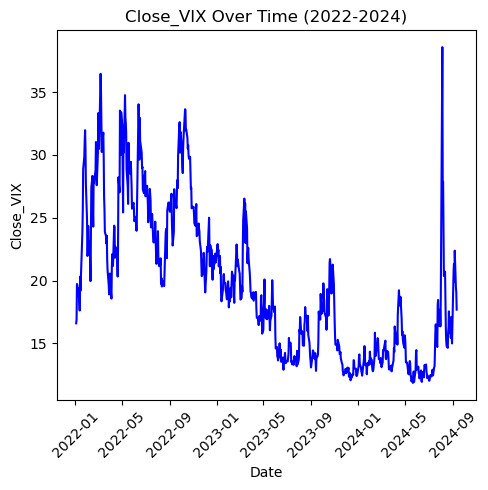

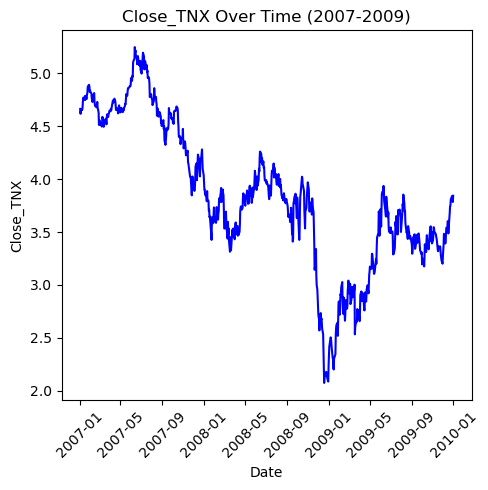

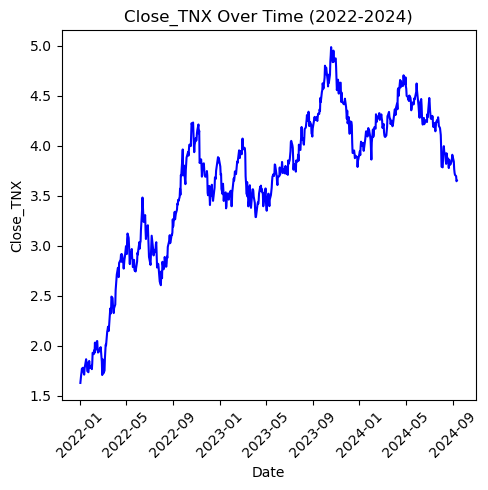

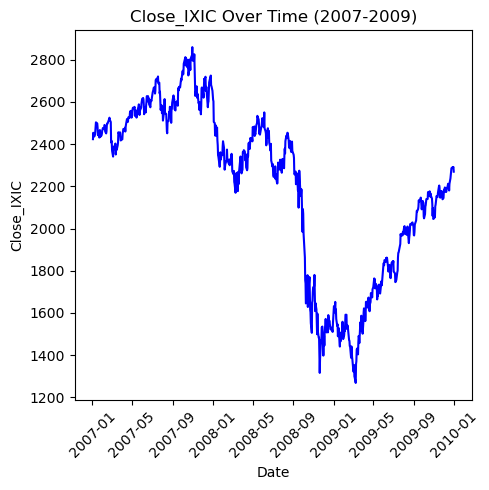

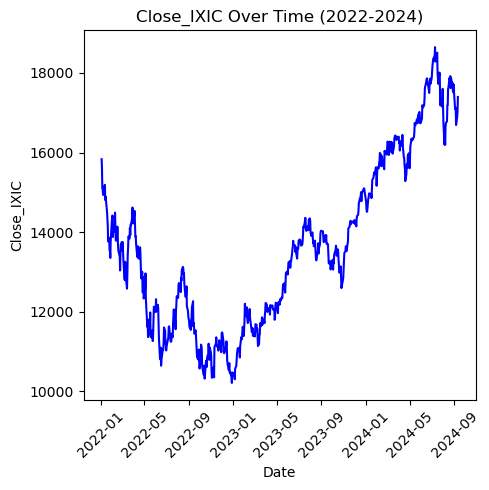

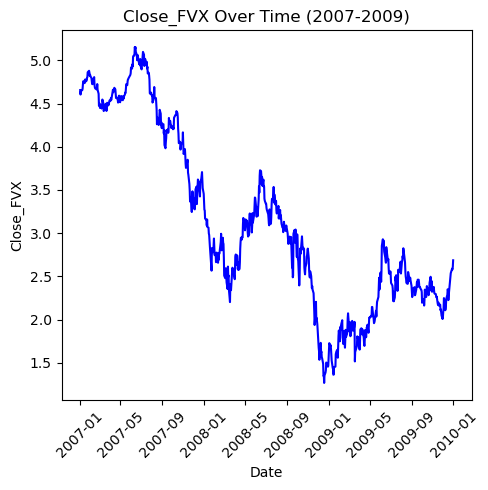

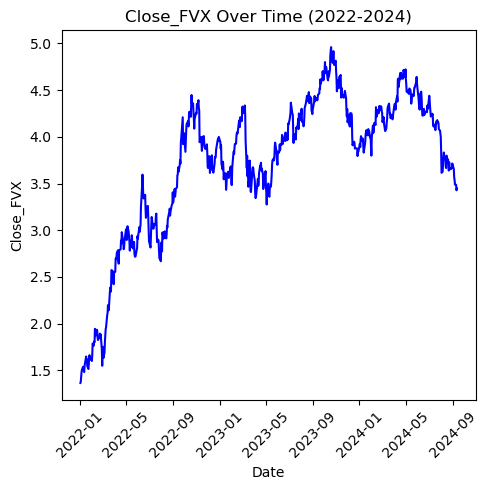

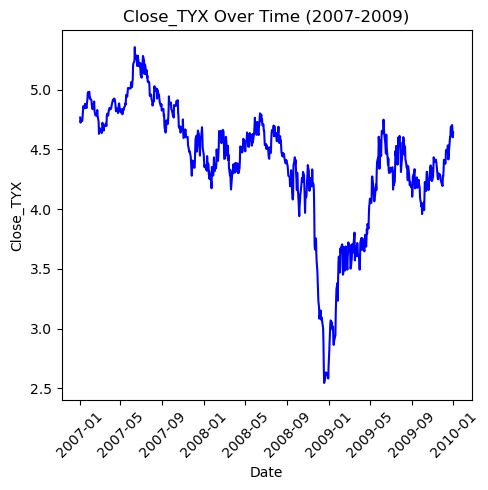

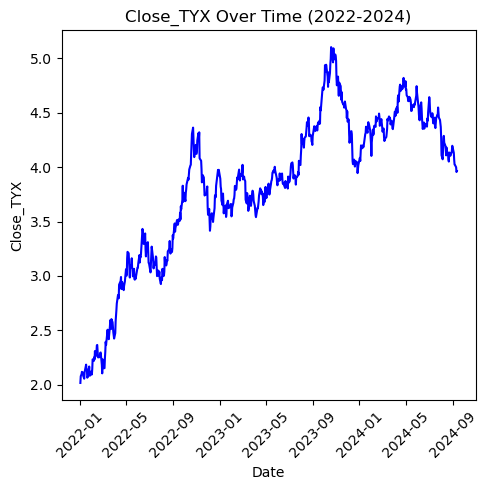

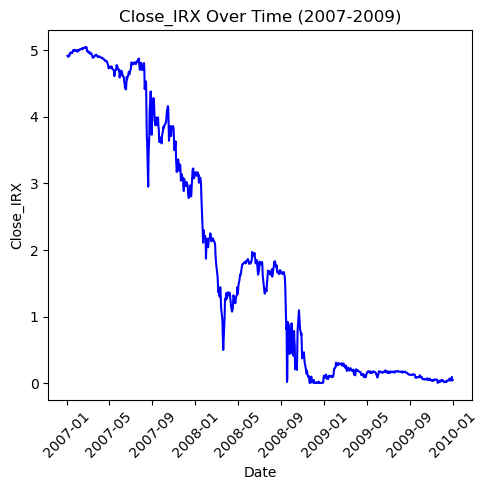

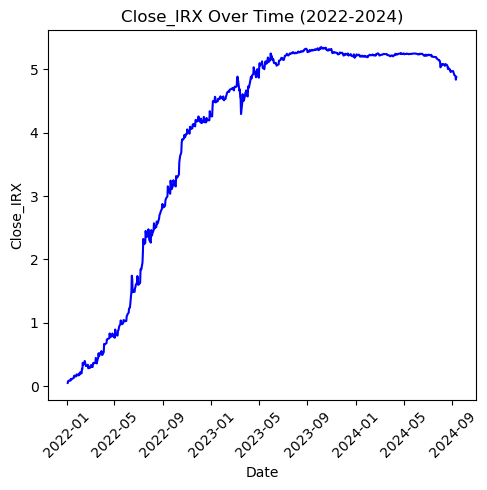

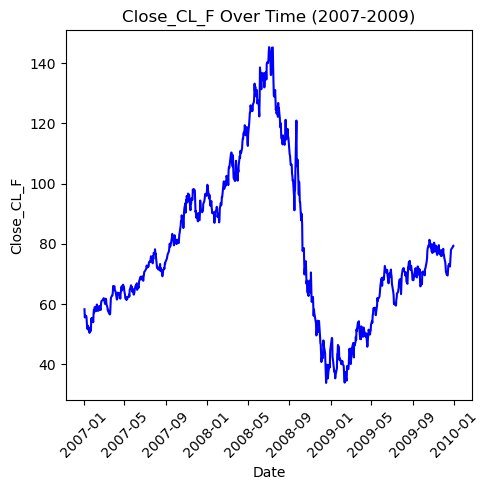

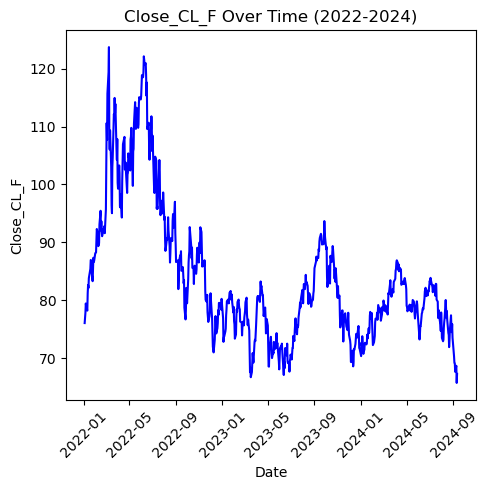

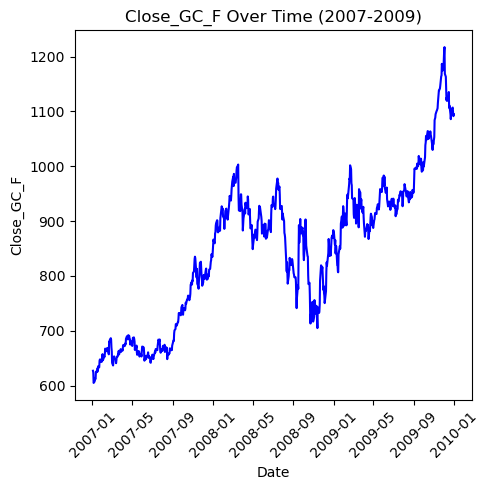

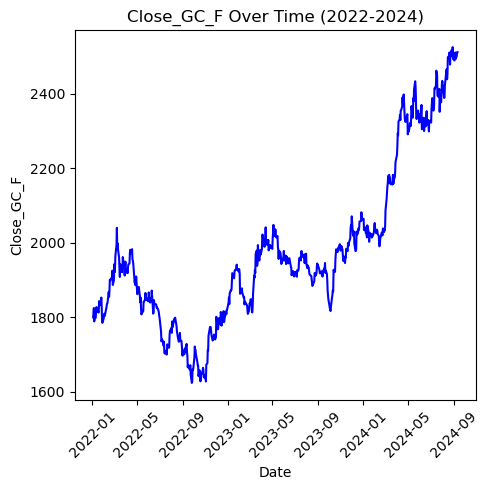

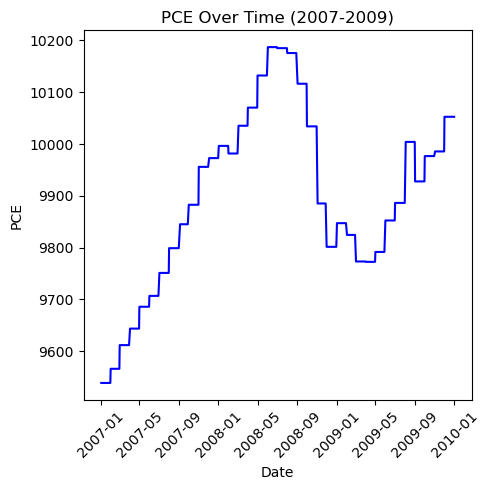

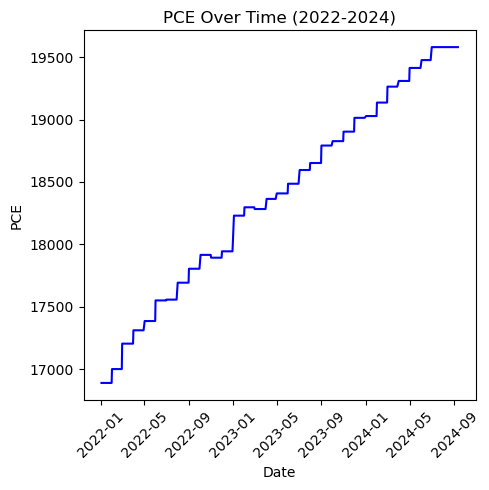

In [178]:
#Question 2
date_ranges = {
    '2007-2009': (pd.Timestamp('2007-01-01'), pd.Timestamp('2009-12-31')),
    '2022-2024': (pd.Timestamp('2022-01-01'), pd.Timestamp('2024-12-31')),
}
for column in df_cleaned.columns:
    if column != 'year':
        for label, (start_date, end_date) in date_ranges.items():
            # Filter the DataFrame for the specified date range
            filtered_data = df_cleaned.loc[start_date:end_date]
            
            # Plot the data
            plt.figure(figsize=(5, 5))
            sns.lineplot(x=filtered_data.index, y=filtered_data[column], color='blue')
            plt.title(f'{column} Over Time ({label})')
            plt.xlabel('Date')
            plt.ylabel(column)
            plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
            plt.tight_layout()  # Adjust layout
            plt.show()

In [179]:
#Question 3
#How do the values of DJI, SPX, VIX, and TNX in December compare in the years 2018-2024? 
#Are there consistent patterns?
#df_cleaned.set_index('Date', inplace=True)
dec_data = df_cleaned[(df_cleaned.index.year >= 2018) & (df_cleaned.index.year <= 2024) & 
                           (df_cleaned.index.month == 12)]
three_mon = dec_data[['Close_DJI','Close_SP_500','Close_VIX','Close_TNX']]
three_mon.head()

Close_DJI  Close_SP_500  Close_VIX  Close_TNX
Date                                                       
2018-12-03  25826.42969   2790.370117  16.440001      2.992
2018-12-04  25027.07031   2700.060059  20.740000      2.924
2018-12-06  24947.66992   2695.949951  21.190001      2.876
2018-12-07  24388.94922   2633.080078  23.230000      2.850
2018-12-10  24423.25977   2637.719971  22.639999      2.856

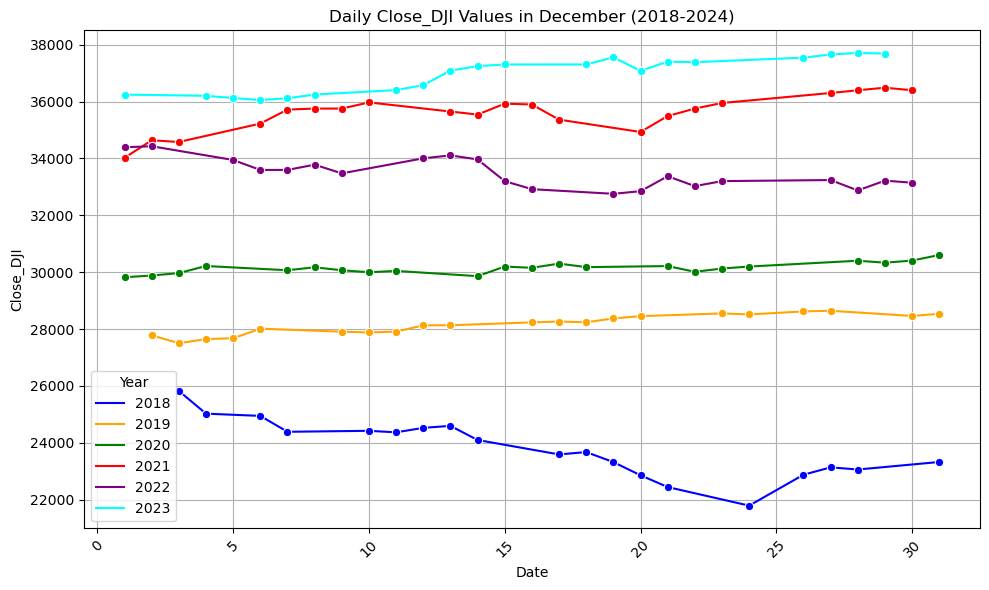

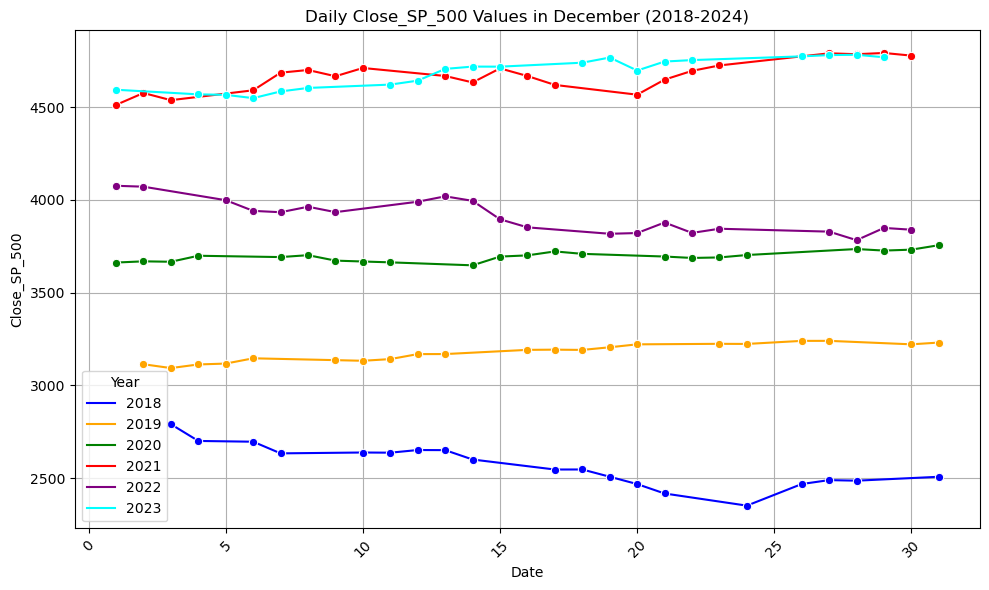

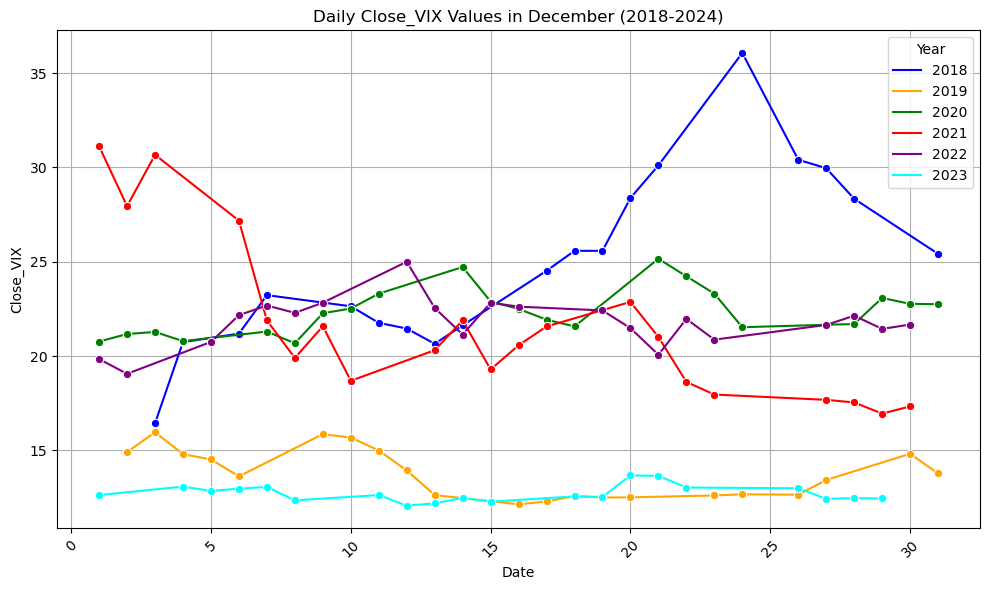

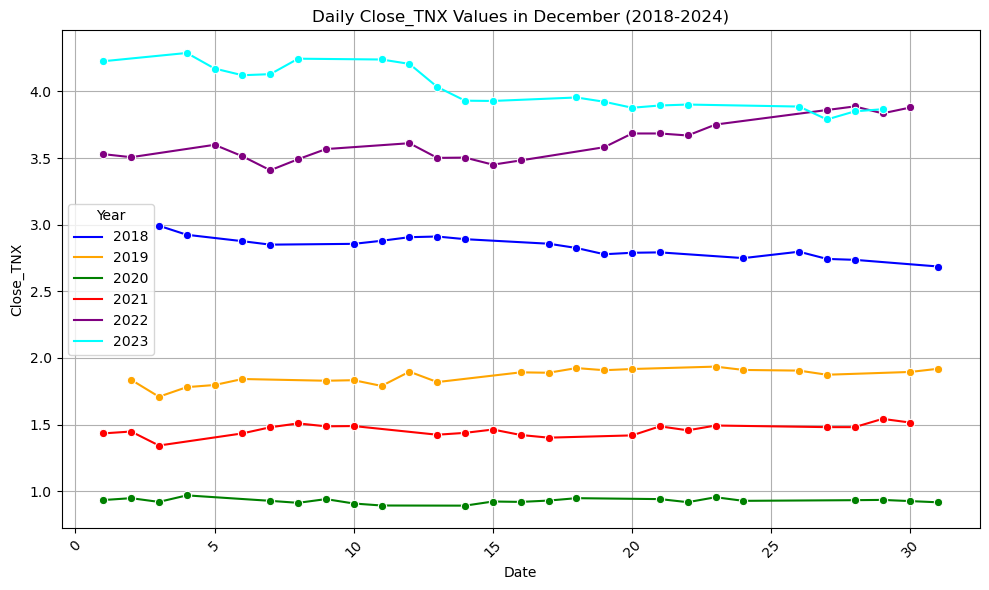

In [180]:
custom_palette = {
    2018: 'blue',
    2019: 'orange',
    2020: 'green',
    2021: 'red',
    2022: 'purple',
    2023: 'cyan',
    2024: 'magenta'
}
for column in three_mon.columns:
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=dec_data, x=dec_data.index.day, y=column, hue=dec_data.index.year, palette=custom_palette,
                 marker='o')
    # Plot format
    plt.title(f'Daily {column} Values in December (2018-2024)')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(title='Year')
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    


In [181]:
df_cleaned.head()

FFER  CPI-U  Core CPI  Unemployment Rate        GDP  \
Date                                                              
2000-08-31  6.65  172.7     181.9                4.1  14145.312   
2000-09-01  6.52  173.6     182.3                3.9  14145.312   
2000-09-05  6.61  173.6     182.3                3.9  14145.312   
2000-09-06  6.56  173.6     182.3                3.9  14145.312   
2000-09-07  6.53  173.6     182.3                3.9  14145.312   

            Nonfarm Payrolls  Close_SP_500    Close_DJI  Close_VIX  Close_TNX  \
Date                                                                            
2000-08-31          132231.0   1517.680054  11215.09961  16.840000      5.729   
2000-09-01          132357.0   1520.770020  11238.78027  17.530001      5.675   
2000-09-05          132357.0   1507.079956  11260.61035  19.820000      5.683   
2000-09-06          132357.0   1492.250000  11310.63965  20.790001      5.712   
2000-09-07          132357.0   1502.510010  11259.87012  19.420000      5.749   

             Close_IXIC  Close_FVX  Close_TYX  Close_IRX  Close_CL_F  \
Date                                                                   
2000-08-31  4206.350098      5.975      5.674       6.11   33.099998   
2000-09-01  4234.330078      5.891      5.655       6.08   33.380001   
2000-09-05  4143.180176      5.905      5.663       6.06   33.799999   
2000-09-06  4013.340088      5.927      5.700       6.01   34.950001   
2000-09-07  4098.350098      5.957      5.713       6.00   35.330002   

            Close_GC_F     PCE  year  
Date                                  
2000-08-31  278.299988  6802.8  2000  
2000-09-01  277.000000  6888.6  2000  
2000-09-05  275.799988  6888.6  2000  
2000-09-06  274.200012  6888.6  2000  
2000-09-07  274.000000  6888.6  2000

## Feature Selection
With time series data, it is important that is it stationary in order to forecast. So, I will start  by using ACF to determine if they are stationary. 

I had already hand-picked the features with educated predictions on what would be important to predict FFER. However, I will 

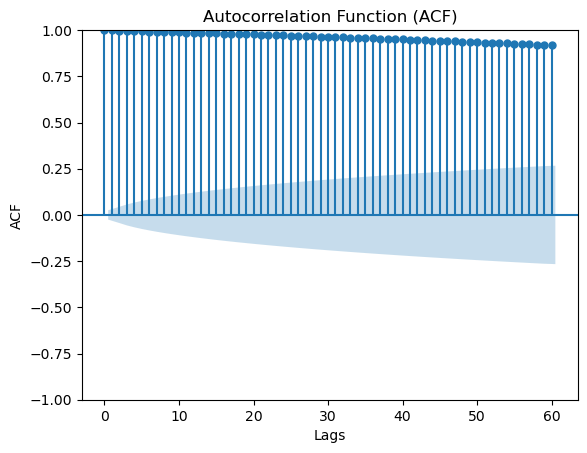

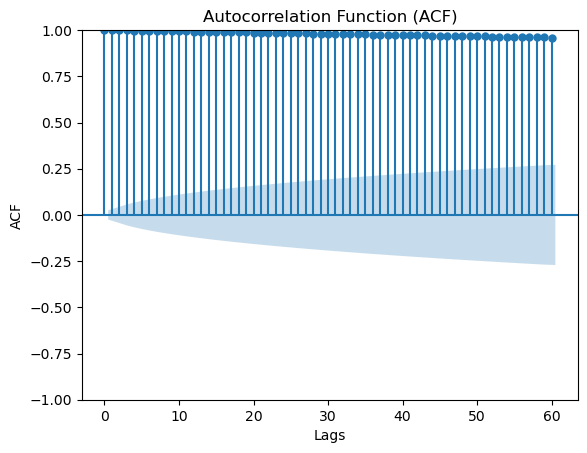

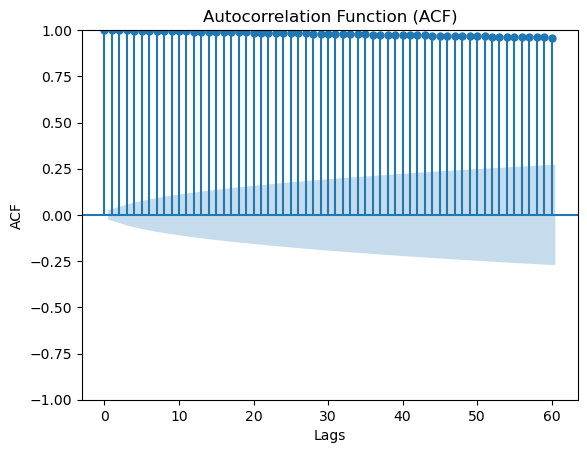

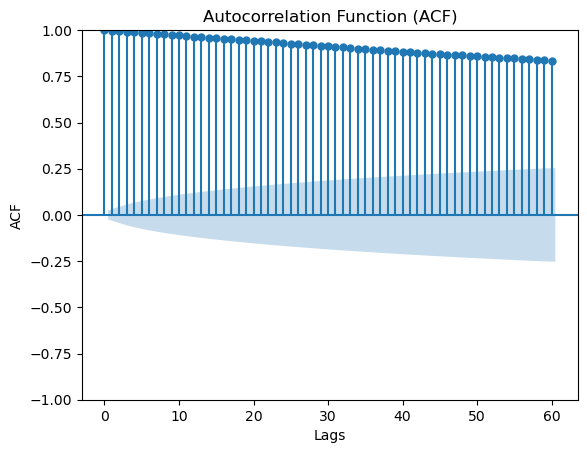

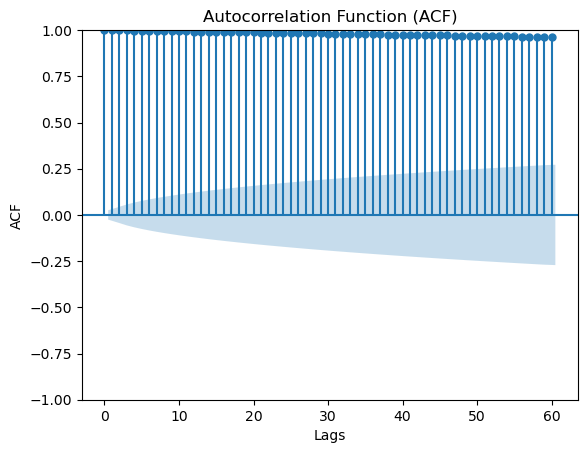

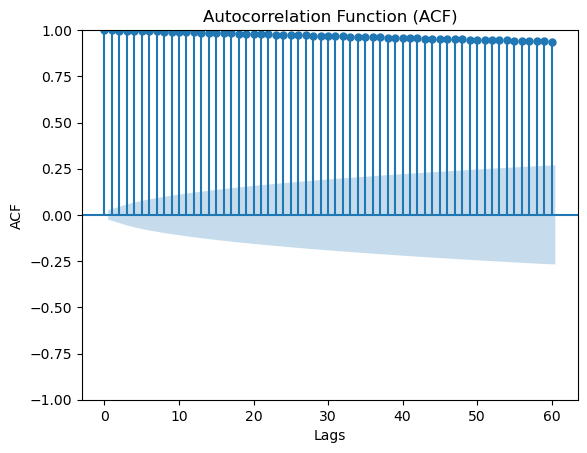

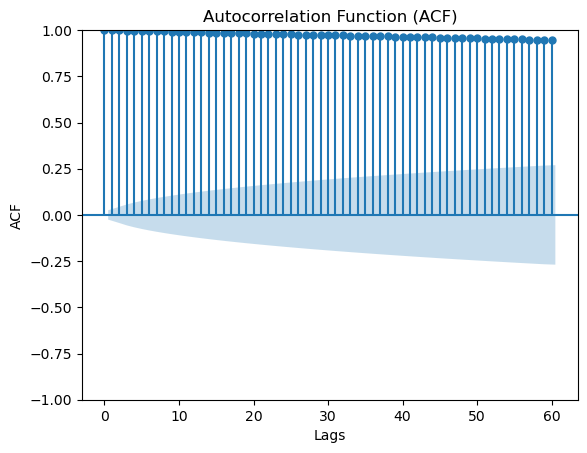

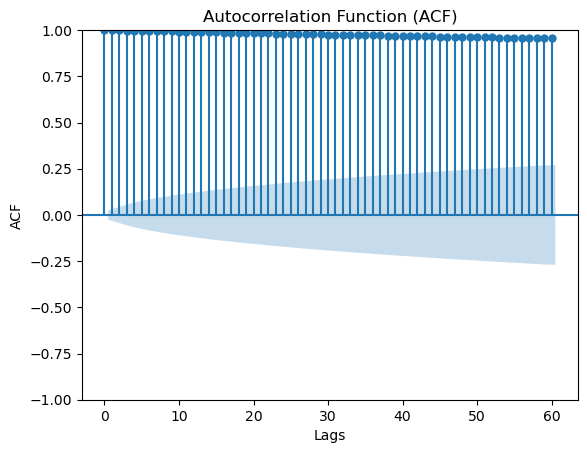

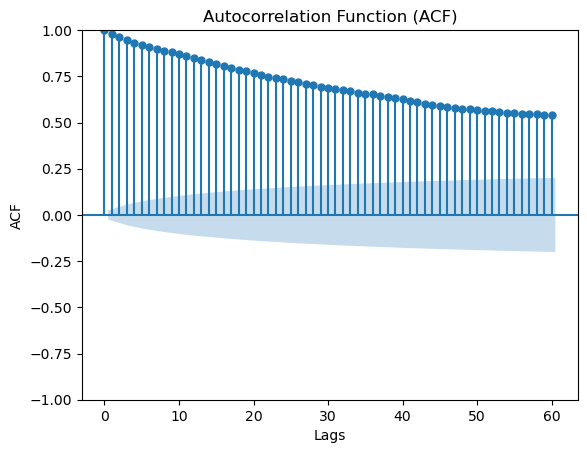

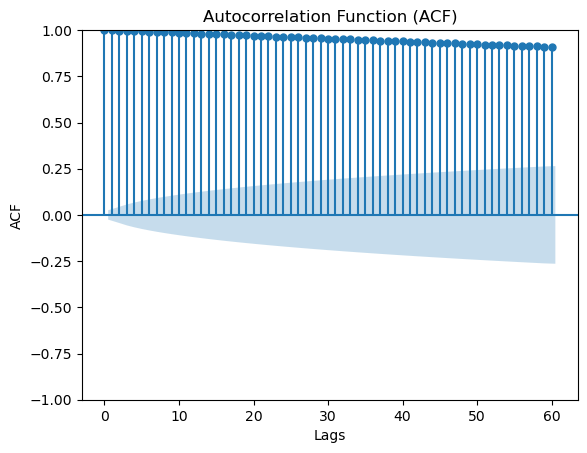

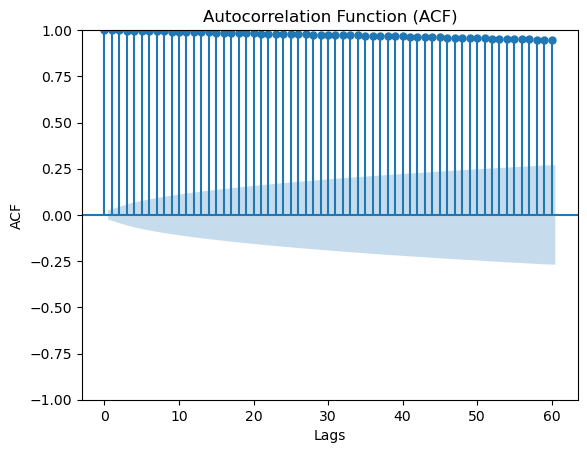

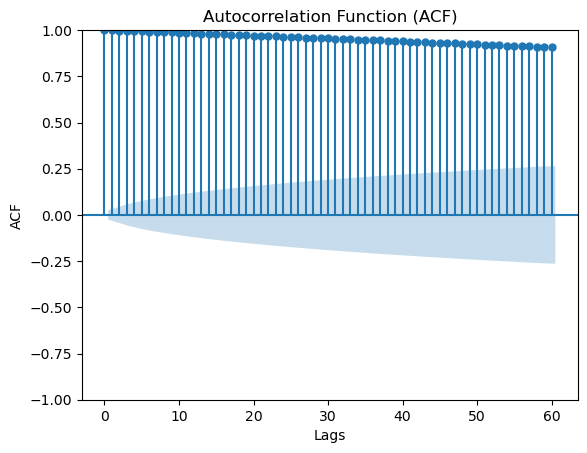

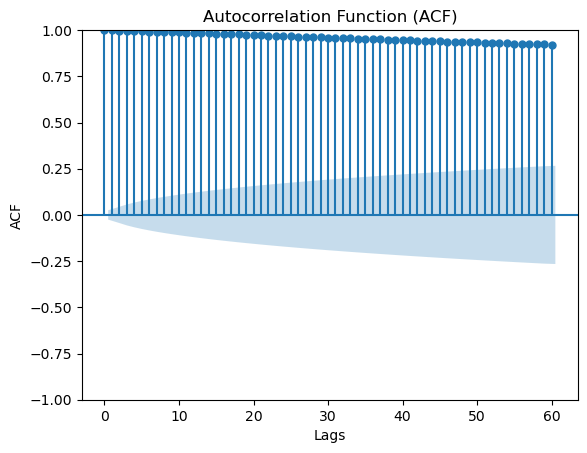

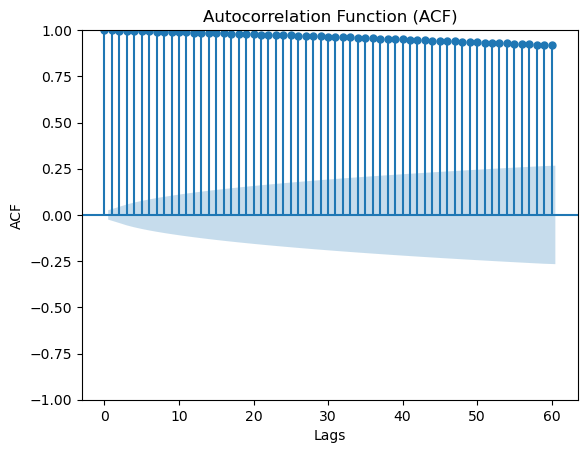

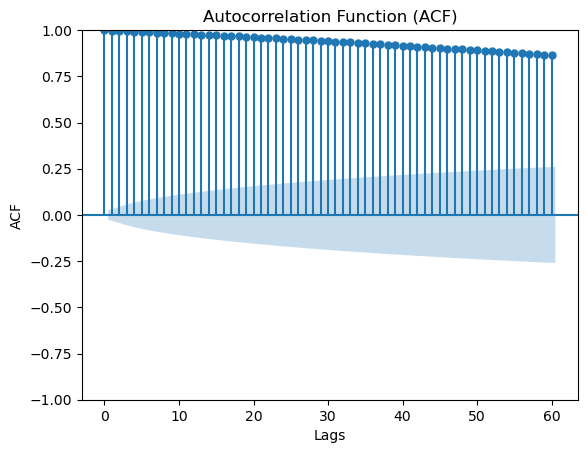

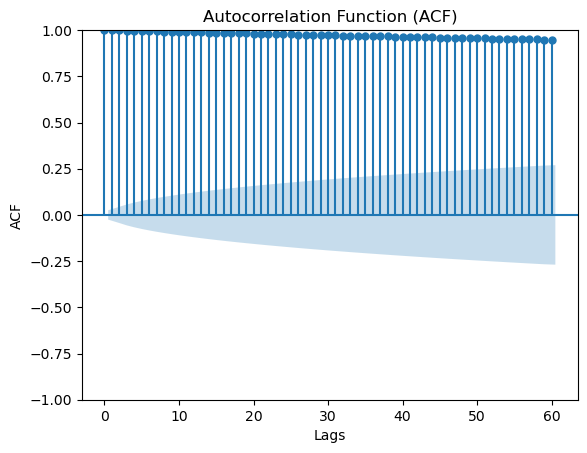

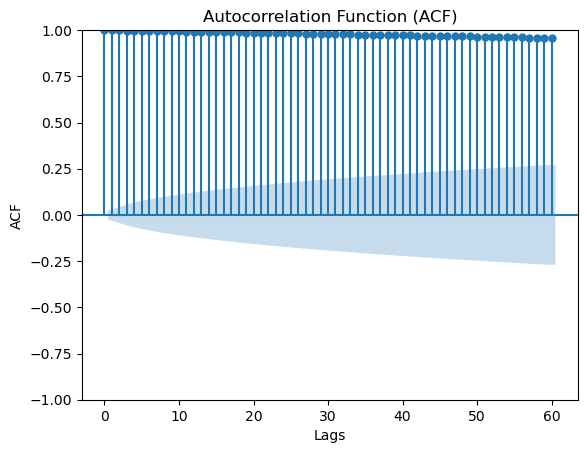

In [182]:
for column in df_cleaned.columns:
    if column != 'Date' and column != 'year':
        plot_acf(df_cleaned[column], lags=60)
        plt.title('Autocorrelation Function (ACF)')
        plt.xlabel('Lags')  # Label for the x-axis
        plt.ylabel('ACF')    # Label for the y-axis
        plt.show()

There exists seasonality and the features and target highly auto-correlated. Auto-correlation with economic indicators makes sense, due to the nature of the industry. Business/economic cycles, inflation trends, and seasonality all play a part as to why these are highly auto-correlated. Although it is an option to make the data stationary, I do not think it is useful for the nature of this model. Economic data is not stationary and the model needs to learn from the seasonality of the data. 

In [183]:
df_cleaned.columns

Index(['FFER', 'CPI-U', 'Core CPI', 'Unemployment Rate', 'GDP',
       'Nonfarm Payrolls', 'Close_SP_500', 'Close_DJI', 'Close_VIX',
       'Close_TNX', 'Close_IXIC', 'Close_FVX', 'Close_TYX', 'Close_IRX',
       'Close_CL_F', 'Close_GC_F', 'PCE', 'year'],
      dtype='object')

In [184]:
#df_cleaned = df_cleaned.drop(columns=['year'])
X = df_cleaned.drop(columns=['FFER'])
y = df_cleaned['FFER']
rfe = RFE(RandomForestRegressor(n_estimators = 100, random_state =1))
fit = rfe.fit(X,y)
feature_ranking = fit.ranking_
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': feature_ranking
}).sort_values(by='Ranking')

In [185]:
features_df.sort_index()

Feature  Ranking
0               CPI-U        1
1            Core CPI        1
2   Unemployment Rate        3
3                 GDP        9
4    Nonfarm Payrolls        1
5        Close_SP_500        8
6           Close_DJI        4
7           Close_VIX        2
8           Close_TNX        7
9          Close_IXIC        1
10          Close_FVX        6
11          Close_TYX        1
12          Close_IRX        1
13         Close_CL_F        1
14         Close_GC_F        5
15                PCE        1
16               year       10

In [186]:
df_final = df_cleaned.drop(columns=['GDP', 'Close_SP_500','year'])

In [187]:
df_final.head()

FFER  CPI-U  Core CPI  Unemployment Rate  Nonfarm Payrolls  \
Date                                                                     
2000-08-31  6.65  172.7     181.9                4.1          132231.0   
2000-09-01  6.52  173.6     182.3                3.9          132357.0   
2000-09-05  6.61  173.6     182.3                3.9          132357.0   
2000-09-06  6.56  173.6     182.3                3.9          132357.0   
2000-09-07  6.53  173.6     182.3                3.9          132357.0   

              Close_DJI  Close_VIX  Close_TNX   Close_IXIC  Close_FVX  \
Date                                                                    
2000-08-31  11215.09961  16.840000      5.729  4206.350098      5.975   
2000-09-01  11238.78027  17.530001      5.675  4234.330078      5.891   
2000-09-05  11260.61035  19.820000      5.683  4143.180176      5.905   
2000-09-06  11310.63965  20.790001      5.712  4013.340088      5.927   
2000-09-07  11259.87012  19.420000      5.749  4098.350098      5.957   

            Close_TYX  Close_IRX  Close_CL_F  Close_GC_F     PCE  
Date                                                              
2000-08-31      5.674       6.11   33.099998  278.299988  6802.8  
2000-09-01      5.655       6.08   33.380001  277.000000  6888.6  
2000-09-05      5.663       6.06   33.799999  275.799988  6888.6  
2000-09-06      5.700       6.01   34.950001  274.200012  6888.6  
2000-09-07      5.713       6.00   35.330002  274.000000  6888.6

## Model Training/Testing

In [188]:
df_final.sort_index(inplace=True)

In [189]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5975 entries, 2000-08-31 to 2024-09-11
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   FFER               5975 non-null   float64
 1   CPI-U              5975 non-null   float64
 2   Core CPI           5975 non-null   float64
 3   Unemployment Rate  5975 non-null   float64
 4   Nonfarm Payrolls   5975 non-null   float64
 5   Close_DJI          5975 non-null   float64
 6   Close_VIX          5975 non-null   float64
 7   Close_TNX          5975 non-null   float64
 8   Close_IXIC         5975 non-null   float64
 9   Close_FVX          5975 non-null   float64
 10  Close_TYX          5975 non-null   float64
 11  Close_IRX          5975 non-null   float64
 12  Close_CL_F         5975 non-null   float64
 13  Close_GC_F         5975 non-null   float64
 14  PCE                5975 non-null   float64
dtypes: float64(15)
memory usage: 875.9 KB


In [190]:
len(df_final)

5975

In [191]:
4780 - 5975

-1195

In [192]:
import keras

In [193]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

#### Seperate data into test and train set before normalization

In [194]:
# Calculate the split index for an 80-20 split
split_index = int(len(df_final) * 0.8)

# Split the data
train = df_final.iloc[:split_index]  # First 80% of the data for training
test = df_final.iloc[split_index:]   # Remaining 20% of the data for testing

features = df_final.drop(columns=['FFER'])
target = df_final['FFER']

### Normalization 

In [195]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [196]:
target.head()

Date
2000-08-31    6.65
2000-09-01    6.52
2000-09-05    6.61
2000-09-06    6.56
2000-09-07    6.53
Name: FFER, dtype: float64

### Define generator
The generator is used to create a window with a number of steps. Each input will contain 365 data points to predict the target. The window is 365 days, and later 365 days will be used to predict the next value. Then, the newly predicted value will be added to the 365 days while the earliest data point is dropped off. 

In [197]:
n_input = 365 #1 year
n_features = 14
generator = TimeseriesGenerator(features,target,length=n_input, batch_size=256)


In [198]:
# Check how many batches are in the generator
total_batches = len(generator)
print(f'Total batches available: {total_batches}')

# Access the first batch (index 0) safely
X, y = generator[0]  # Change the index if needed, e.g., generator[1] for the second batch

# Print the inputs and expected output
print(f'Given the Array: \n{X.flatten()}')  
print(f'Predict this y: \n{y.flatten()}')

Total batches available: 22
Given the Array: 
[1.7270000e+02 1.8190000e+02 4.1000000e+00 ... 3.6720001e+01 3.5050000e+02
 7.6115000e+03]
Predict this y: 
[1.78 1.68 1.63 1.71 1.77 1.69 1.75 1.68 1.73 1.79 1.8  1.71 1.67 1.78
 1.74 1.68 1.75 1.71 1.69 1.77 1.88 1.74 1.81 1.74 1.7  1.72 1.68 1.73
 1.83 1.79 1.84 1.68 1.73 1.71 1.67 1.73 1.71 1.76 1.82 1.79 1.81 1.82
 1.88 1.79 1.73 1.75 1.72 1.71 1.74 1.74 1.75 1.69 1.84 1.76 1.7  1.72
 1.68 1.73 1.76 1.75 1.88 1.79 1.8  1.79 1.83 1.73 1.7  1.75 1.73 1.76
 1.72 1.75 1.76 1.75 1.82 1.71 1.69 1.75 1.74 1.77 1.75 1.78 1.81 1.73
 1.83 1.72 1.71 1.75 1.72 1.74 1.76 1.71 1.83 1.72 1.71 1.74 1.72 1.77
 1.73 1.67 1.75 1.69 1.75 1.71 1.76 1.79 1.72 1.77 1.74 1.71 1.71 1.68
 1.76 1.74 1.78 1.87 1.7  1.72 1.7  1.72 1.73 1.72 1.81 1.79 1.8  1.82
 1.81 1.87 1.74 1.75 1.71 1.76 1.74 1.72 1.74 1.72 1.83 1.72 1.68 1.69
 1.7  1.74 1.75 1.79 1.8  1.78 1.85 1.85 1.75 1.76 1.72 1.74 1.72 1.73
 1.75 1.73 1.88 1.73 1.74 1.71 1.73 1.71 1.76 1.8  1.82 1.79 1.75

In [199]:
X.shape

(256, 365, 14)

In [200]:
y.shape

(256,)

In [201]:
y = np.expand_dims(y, axis=1)  # This will reshape y to be (256, 1)

In [202]:
y.shape

(256, 1)

In [203]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input

In [204]:
#Define model 
model = Sequential()
model.add(Input(shape=(n_input, n_features))) 
model.add(LSTM(100,activation='tanh',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss = 'mse')

/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [205]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 100)            │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,101 (180.08 KB)

 Trainable params: 46,101 (180.08 KB)

 Non-trainable params: 0 (0.00 B)

In [206]:
model.fit(generator,epochs = 50)

Epoch 1/50


/opt/anaconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 464ms/step - loss: 4.6771
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - loss: 4.9080
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - loss: 5.2533
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 458ms/step - loss: 2.9253
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - loss: 3.1719
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 460ms/step - loss: 2.8164
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - loss: 3.0988
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step - loss: 4.1672
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step - loss: 2.5253
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 476ms/step - loss: 2.9864
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 479ms/step - loss: 2.9110
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step - loss: 1.7204
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 467ms/step - loss: 2.8967
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step - loss: 2.2094
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 484ms/step 

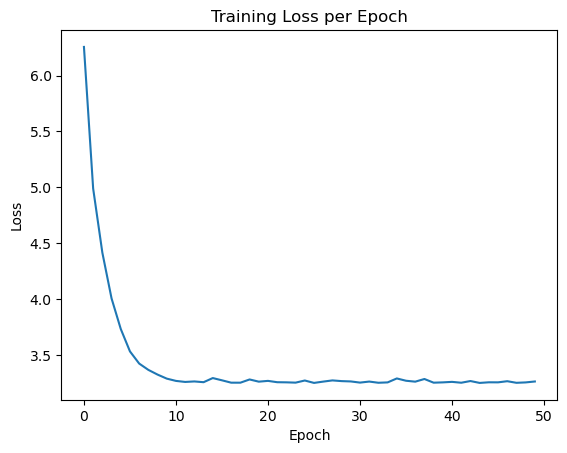

In [208]:
#plotting the loss function
loss_per_epoch = model.history.history['loss']
plt.plot(loss_per_epoch); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss per Epoch'); plt.show()




#### Analysis: 
A decreasing training loss generally indicates that the model is improving and learning patterns in the training data. 

In [209]:
feature_test = test['FFER']

In [210]:
train = train.drop(columns = ['FFER'])
test = test.drop(columns = ['FFER'])

In [212]:
last_train_batch = train[-n_input:] # taking the last 365 days of data

In [213]:
print(train.shape)

(4780, 14)


In [214]:
print(test.shape)

(4780, 14)


In [215]:
test.head()

CPI-U  Core CPI  Unemployment Rate  Nonfarm Payrolls    Close_DJI  \
Date                                                                            
2005-07-11  194.9     200.9                5.0          134297.0  10519.71973   
2005-07-12  194.9     200.9                5.0          134297.0  10513.88965   
2005-07-13  194.9     200.9                5.0          134297.0  10557.38965   
2005-07-14  194.9     200.9                5.0          134297.0  10628.88965   
2005-07-15  194.9     200.9                5.0          134297.0  10640.83008   

            Close_VIX  Close_TNX   Close_IXIC  Close_FVX  Close_TYX  \
Date                                                                  
2005-07-11      11.28      4.102  2135.429932      3.901      4.342   
2005-07-12      10.95      4.141  2143.149902      3.937      4.383   
2005-07-13      10.84      4.163  2144.110107      3.959      4.398   
2005-07-14      10.81      4.180  2152.820068      3.976      4.417   
2005-07-15      10.33      4.175  2156.780029      3.977      4.405   

            Close_IRX  Close_CL_F  Close_GC_F     PCE  
Date                                                   
2005-07-11      3.095   58.919998  425.500000  8853.8  
2005-07-12      3.135   60.619999  426.299988  8853.8  
2005-07-13      3.145   60.009998  423.899994  8853.8  
2005-07-14      3.152   57.799999  419.600006  8853.8  
2005-07-15      3.178   58.090000  420.700012  8853.8

In [216]:
train.head()

CPI-U  Core CPI  Unemployment Rate  Nonfarm Payrolls    Close_DJI  \
Date                                                                            
2000-08-31  172.7     181.9                4.1          132231.0  11215.09961   
2000-09-01  173.6     182.3                3.9          132357.0  11238.78027   
2000-09-05  173.6     182.3                3.9          132357.0  11260.61035   
2000-09-06  173.6     182.3                3.9          132357.0  11310.63965   
2000-09-07  173.6     182.3                3.9          132357.0  11259.87012   

            Close_VIX  Close_TNX   Close_IXIC  Close_FVX  Close_TYX  \
Date                                                                  
2000-08-31  16.840000      5.729  4206.350098      5.975      5.674   
2000-09-01  17.530001      5.675  4234.330078      5.891      5.655   
2000-09-05  19.820000      5.683  4143.180176      5.905      5.663   
2000-09-06  20.790001      5.712  4013.340088      5.927      5.700   
2000-09-07  19.420000      5.749  4098.350098      5.957      5.713   

            Close_IRX  Close_CL_F  Close_GC_F     PCE  
Date                                                   
2000-08-31       6.11   33.099998  278.299988  6802.8  
2000-09-01       6.08   33.380001  277.000000  6888.6  
2000-09-05       6.06   33.799999  275.799988  6888.6  
2000-09-06       6.01   34.950001  274.200012  6888.6  
2000-09-07       6.00   35.330002  274.000000  6888.6

In [217]:
last_train_batch.shape

(365, 14)

In [218]:
last_train_batch_np = last_train_batch.to_numpy()

In [219]:
last_train_batch_np.shape

(365, 14)

In [220]:
last_train_batch = last_train_batch_np.reshape((1, n_input, n_features))

In [273]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[1.5888518]], dtype=float32)

In [274]:
target[365]

1.78

#### Quick Analysis
* Prediction = 1.588%
* Actual = 1.78%
These are the acutal values. These are not normalized. 

In [275]:
target.head()

Date
2000-08-31    6.65
2000-09-01    6.52
2000-09-05    6.61
2000-09-06    6.56
2000-09-07    6.53
Name: FFER, dtype: float64

In [276]:
test_predictions = []
first_eval_batch = train[-n_input:]

In [277]:
type(first_eval_batch)

pandas.core.frame.DataFrame

In [278]:
first_eval_batch = first_eval_batch.to_numpy()

In [279]:
current_batch = first_eval_batch.reshape((1, n_input, n_features))

In [280]:
current_batch.shape

(1, 365, 14)

In [281]:
type(current_batch)

numpy.ndarray

In [282]:
"""
This block of code creates a rolling prediction for the time series forecasting model. The next value is predicted 
iteratively based on the previous batch of data, then appends that prediction, and deletes the oldest value. 
Essentially, the window is sliding forward when adding the new prediction. It's purpose is to continuously predict
future values based on the past observations, and move the window of values in order to do so. 
"""
for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred)
    # Append the prediction to the current batch
    # Reshape the prediction to match the input shape
    current_pred_repeated = np.repeat(current_pred,14).reshape(1,1,14)

  # Update the current_batch: append the prediction and drop the first input
    # current_batch[0, :-1] keeps the last 364 days, then append the new prediction
    current_batch = np.append(current_batch[:, 1:], current_pred_repeated, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [283]:
test_predictions

[array([1.5888518], dtype=float32),
 array([0.960144], dtype=float32),
 array([0.84002703], dtype=float32),
 array([0.7728015], dtype=float32),
 array([0.7091011], dtype=float32),
 array([0.6495623], dtype=float32),
 array([0.595866], dtype=float32),
 array([0.54876757], dtype=float32),
 array([0.508714], dtype=float32),
 array([0.47639614], dtype=float32),
 array([0.45249888], dtype=float32),
 array([0.43687674], dtype=float32),
 array([0.42783648], dtype=float32),
 array([0.42031336], dtype=float32),
 array([0.40312496], dtype=float32),
 array([0.36506248], dtype=float32),
 array([0.307477], dtype=float32),
 array([0.24005997], dtype=float32),
 array([0.17138481], dtype=float32),
 array([0.10674103], dtype=float32),
 array([0.04812597], dtype=float32),
 array([-0.0017508], dtype=float32),
 array([-0.03721488], dtype=float32),
 array([-0.05380545], dtype=float32),
 array([-0.05260173], dtype=float32),
 array([-0.03897033], dtype=float32),
 array([-0.01873063], dtype=float32),
 array([

In [270]:
test.head()

CPI-U  Core CPI  Unemployment Rate  Nonfarm Payrolls    Close_DJI  \
Date                                                                            
2005-07-11  194.9     200.9                5.0          134297.0  10519.71973   
2005-07-12  194.9     200.9                5.0          134297.0  10513.88965   
2005-07-13  194.9     200.9                5.0          134297.0  10557.38965   
2005-07-14  194.9     200.9                5.0          134297.0  10628.88965   
2005-07-15  194.9     200.9                5.0          134297.0  10640.83008   

            Close_VIX  Close_TNX   Close_IXIC  Close_FVX  Close_TYX  \
Date                                                                  
2005-07-11      11.28      4.102  2135.429932      3.901      4.342   
2005-07-12      10.95      4.141  2143.149902      3.937      4.383   
2005-07-13      10.84      4.163  2144.110107      3.959      4.398   
2005-07-14      10.81      4.180  2152.820068      3.976      4.417   
2005-07-15      10.33      4.175  2156.780029      3.977      4.405   

            Close_IRX  Close_CL_F  Close_GC_F     PCE  
Date                                                   
2005-07-11      3.095   58.919998  425.500000  8853.8  
2005-07-12      3.135   60.619999  426.299988  8853.8  
2005-07-13      3.145   60.009998  423.899994  8853.8  
2005-07-14      3.152   57.799999  419.600006  8853.8  
2005-07-15      3.178   58.090000  420.700012  8853.8

In [284]:
test_predictions = np.array(test_predictions).reshape(-1, 1)

In [285]:
# Now create a full 2D array to match the scaler's expected shape
expanded_predictions = np.zeros((test_predictions.shape[0], 15))
expanded_predictions[:, 0] = test_predictions.flatten() # Place your predictions in 

In [286]:
true_predictions = scaler.inverse_transform(expanded_predictions)

In [287]:
true_predictions

array([[1.05899760e+01, 1.72700000e+02, 1.81900000e+02, ...,
        1.74500010e+01, 2.55100006e+02, 6.80280000e+03],
       [6.41535605e+00, 1.72700000e+02, 1.81900000e+02, ...,
        1.74500010e+01, 2.55100006e+02, 6.80280000e+03],
       [5.61777951e+00, 1.72700000e+02, 1.81900000e+02, ...,
        1.74500010e+01, 2.55100006e+02, 6.80280000e+03],
       ...,
       [5.85043945e-01, 1.72700000e+02, 1.81900000e+02, ...,
        1.74500010e+01, 2.55100006e+02, 6.80280000e+03],
       [5.85043945e-01, 1.72700000e+02, 1.81900000e+02, ...,
        1.74500010e+01, 2.55100006e+02, 6.80280000e+03],
       [5.85043945e-01, 1.72700000e+02, 1.81900000e+02, ...,
        1.74500010e+01, 2.55100006e+02, 6.80280000e+03]])

In [241]:
print(test.shape)
print(true_predictions.shape)

(4780, 14)
(4780, 15)


In [245]:
target_filtered = target[365:]

In [258]:
target_filtered_df = target_filtered.to_frame()

In [264]:
# I wanted to add the true predictions to the target data set to easily compare. However, the shape is not the same 
target_filtered_df['Predictions'] = true_predictions[:, 0]

ValueError: Length of values (4780) does not match length of index (5611)

In [260]:
test.head()

CPI-U  Core CPI  Unemployment Rate  Nonfarm Payrolls    Close_DJI  \
Date                                                                            
2005-07-11  194.9     200.9                5.0          134297.0  10519.71973   
2005-07-12  194.9     200.9                5.0          134297.0  10513.88965   
2005-07-13  194.9     200.9                5.0          134297.0  10557.38965   
2005-07-14  194.9     200.9                5.0          134297.0  10628.88965   
2005-07-15  194.9     200.9                5.0          134297.0  10640.83008   

            Close_VIX  Close_TNX   Close_IXIC  Close_FVX  Close_TYX  \
Date                                                                  
2005-07-11      11.28      4.102  2135.429932      3.901      4.342   
2005-07-12      10.95      4.141  2143.149902      3.937      4.383   
2005-07-13      10.84      4.163  2144.110107      3.959      4.398   
2005-07-14      10.81      4.180  2152.820068      3.976      4.417   
2005-07-15      10.33      4.175  2156.780029      3.977      4.405   

            Close_IRX  Close_CL_F  Close_GC_F     PCE  
Date                                                   
2005-07-11      3.095   58.919998  425.500000  8853.8  
2005-07-12      3.135   60.619999  426.299988  8853.8  
2005-07-13      3.145   60.009998  423.899994  8853.8  
2005-07-14      3.152   57.799999  419.600006  8853.8  
2005-07-15      3.178   58.090000  420.700012  8853.8

In [261]:
df_final['FFER']

Date
2000-08-31    6.65
2000-09-01    6.52
2000-09-05    6.61
2000-09-06    6.56
2000-09-07    6.53
              ... 
2024-09-05    5.33
2024-09-06    5.33
2024-09-09    5.33
2024-09-10    5.33
2024-09-11    5.33
Name: FFER, Length: 5975, dtype: float64

## Model Evaluation 


In [263]:
# plot the true predictions against the the FFER actual values 
target_filtered_df.plot(figsize=(14,5))

TypeError: no numeric data to plot

### Mean Squared Error Calculation

In [250]:
mse = model.evaluate(generator)
mse

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 2.7149


3.2433667182922363

#### Analysis:
The mse value communicates how well the model is performing. The mse value above is 3.24, communicating that the average squared difference between the predicted and the actual values is 3.24. The values of FFER are around 1-6%, so this indicates predicition errors. 

In [251]:
test.head()

CPI-U  Core CPI  Unemployment Rate  Nonfarm Payrolls    Close_DJI  \
Date                                                                            
2005-07-11  194.9     200.9                5.0          134297.0  10519.71973   
2005-07-12  194.9     200.9                5.0          134297.0  10513.88965   
2005-07-13  194.9     200.9                5.0          134297.0  10557.38965   
2005-07-14  194.9     200.9                5.0          134297.0  10628.88965   
2005-07-15  194.9     200.9                5.0          134297.0  10640.83008   

            Close_VIX  Close_TNX   Close_IXIC  Close_FVX  Close_TYX  \
Date                                                                  
2005-07-11      11.28      4.102  2135.429932      3.901      4.342   
2005-07-12      10.95      4.141  2143.149902      3.937      4.383   
2005-07-13      10.84      4.163  2144.110107      3.959      4.398   
2005-07-14      10.81      4.180  2152.820068      3.976      4.417   
2005-07-15      10.33      4.175  2156.780029      3.977      4.405   

            Close_IRX  Close_CL_F  Close_GC_F     PCE  
Date                                                   
2005-07-11      3.095   58.919998  425.500000  8853.8  
2005-07-12      3.135   60.619999  426.299988  8853.8  
2005-07-13      3.145   60.009998  423.899994  8853.8  
2005-07-14      3.152   57.799999  419.600006  8853.8  
2005-07-15      3.178   58.090000  420.700012  8853.8

In [252]:
print(test.shape)
print(train.shape)

(4780, 14)
(4780, 14)


In [253]:
# 
#squares the errors before averaging them, giving more weight to larger errors.
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(target,test['Predictions']))
print(rmse)

KeyError: 'Predictions'

In [ ]:
df_final.shape